In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jax_np
from jax import vmap as jax_vmap
from jax import grad as jax_grad
from jax import jit as jax_jit
from jax import random as jax_ran
from jax.experimental import stax,optimizers
from jax.experimental.stax import Dense, Relu

# Load data

In [2]:
dataset=np.load('data_ML_Nfreq100_Nbeta20_Nlambda20.npz',allow_pickle=True)
print(dataset.files)

['data', 'freq', 'params']


In [3]:
S= dataset['data']
Fr= dataset['freq']
parametre= dataset['params']



# I. For pre_processing we are going to use $S$ and $parametre$

###  1. Using $S$ for pre_processing

In [4]:
S=np.copy(S)
parametre=np.copy(parametre)

In [5]:
S.shape

(40000, 256, 3)

In [6]:
S=S[0:400,:,:]

In [7]:
S.shape

(400, 256, 3)

In [8]:
S[0,0,0]

(1.5750298860556053e-26+6.942531679368237e-27j)

/Users/ky266509/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


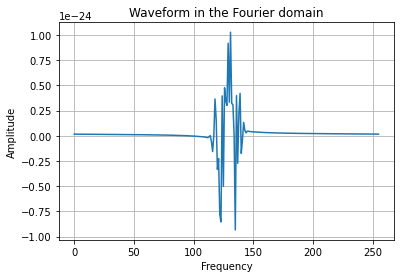

In [9]:
plt.plot(S[0,:,0])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Waveform in the Fourier domain')
plt.grid()


In [10]:
parameter=parametre[0:400,:]

In [11]:
parameter

array([[ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -3.14159265e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.81089869e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.48020473e+00],
       ...,
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  1.57079633e+00,  2.48020473e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  1.57079633e+00,  2.81089869e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  1.57079633e+00,  3.14159265e+00]])

####  a. Normalisation

- $ \overline{S_i}=\frac{S_i}{\rVert S_i \lVert_2},\quad \forall i \in \overline{0,400}$

In [12]:
# cette fonction normalise seulement une forme d'onde pour un canal "X","Y","Z"
def normalize(S,n,e):
# n nombre de FO, e nombre de canal
    
    return np.asarray([S[n,i,e]/np.linalg.norm(S[n,:,e]) for i in range(S.shape[1])])

# return un tableau contenant chaque forme d'onde normalisée

In [13]:
S1=normalize(S,10,0)
S1.shape

(256,)

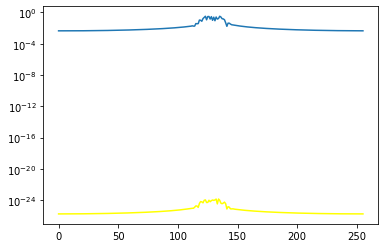

In [14]:
#plt.figure(figsize=(20,12))
plt.semilogy(np.abs(S1))
plt.semilogy(np.abs(S[0,:,0]),color='yellow')
#plt.semilogy(np.abs(S_canalXYZ[0,:,0]),color='red')

In [15]:
nb_fo=400 # nombre de FO utilisable pour l'apprentissage du réseau de neurones (400)

In [16]:
# cette fonction rassemble toutes les formes d'onde normalisée dans un seul tableau 
# n nombre de forme d'onde , e numéro du  canal ("X","Y","Z")
def norm(S):
    
    return (np.asarray([[normalize(S,n,e) for e in range (S.shape[-1])] for n in range(nb_fo)]))
# pour les n=400 premières formes d'ondes

In [17]:
S_bar=norm(S)


In [18]:
S_bar.shape

(400, 3, 256)

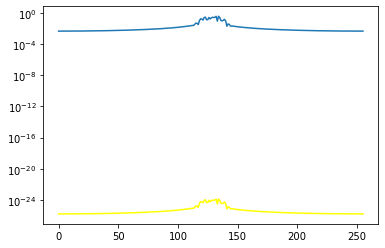

In [19]:
#plt.figure(figsize=(20,12))
plt.semilogy(np.abs(S_bar[0,0,:]))
plt.semilogy(np.abs(S[0,:,0]),color='yellow')
#plt.sem

####  b. Génération de v.a uniforme 

- $ \tilde{S_{i,k}}= \alpha_k \times \overline{S_i},\quad \forall i \in [0,1,...,400] ,\quad k \in \overline{0,5}\quad avec \quad \alpha_k = \sqrt\frac{N\times\mathrm{X}_k}{2}\quad tq \quad \mathrm{X}_k \to \cup(1,20)$



- $ SNR=\frac{2}{N}\sum_{k=0}\frac{\lvert \tilde{S_{i,k}\rvert}{\sigma_k}$

In [20]:
 
X=np.array([np.random.uniform(1,20,5) for _ in range(nb_fo)])
X[10]

array([ 4.11446747, 15.67665504, 11.5924399 , 17.38613775,  4.03328098])

In [21]:
alpha=np.sqrt(256*X/2)
alpha

array([[35.97653249, 49.1763599 , 32.45406392, 48.49611539, 39.24731639],
       [42.59017781, 36.74216375, 38.3571389 , 38.40556866, 44.5692552 ],
       [29.96180109, 34.64028656, 33.88998025, 30.18816528, 24.22526101],
       ...,
       [43.82719514, 36.68781992, 47.98420764, 43.3939497 , 24.94325648],
       [46.01669732, 15.98696379, 35.11732555, 16.92549573, 42.54864679],
       [48.90908331, 31.64970295, 29.90205698, 49.82310726, 39.59023507]])

In [22]:
# multiplication de X par chaque FO
def amplitude(S,n):
    
    return np.asarray([S[n,:,:]*i for i in alpha[n]])

In [23]:
# cette fonction retourne les 5 amplitudes différentes de chaque FO
def amp(S):
     
    return (np.asarray([amplitude(S,n) for n in range(nb_fo)])).reshape((-1,3,256))
# chaque FO retourne 5 sous formes d'onde d'amplitude différentes chacune ayant 2827 fréquences 





In [24]:
S_tilde=amp(S_bar)

In [25]:
S_tilde.shape

(2000, 3, 256)

###  2. Using $parametre $ for pre_processing

####  a. Parameters used for learning

-  Amplitude $h_0$
-  Latitude Ecliptic $\beta$
-  Ecliptic Longitude $\lambda$

In [26]:
amplitude=parametre[:,0] # amplitude
beta=parametre[:,6] # bêta
lamb=parametre[:,7] # lambda
#parameters=[]
#zz=np.concatenate((amplitude[0:2],beta[0:2]))
parameters=np.asarray([(i,j,k)for i,j,k in zip(amplitude,beta,lamb)] )

parameters.shape



(40000, 3)

In [27]:
parameters

array([[ 1.00000000e-22,  0.00000000e+00, -3.14159265e+00],
       [ 1.00000000e-22,  0.00000000e+00, -2.81089869e+00],
       [ 1.00000000e-22,  0.00000000e+00, -2.48020473e+00],
       ...,
       [ 1.00000000e-22,  1.57079633e+00,  2.48020473e+00],
       [ 1.00000000e-22,  1.57079633e+00,  2.81089869e+00],
       [ 1.00000000e-22,  1.57079633e+00,  3.14159265e+00]])

-  $ \overline{h}=[h_i]=\frac{h_0}{\rVert S_i \lVert_2},\forall i \quad\text{allant de 0 à nb_fo}$

 -  $\tilde{h}=[h_i]\times\mathrm{X}_j ,\forall i \in  \overline{0,nb}\quad et\quad j \in\overline{0,5}\quad avec \quad  \mathrm{X} \to \cup(1,10) $

$$
 \forall i \in [1,2,..400],\begin{array}{|c|c|c|c|c|}
\hline
\beta & \lambda & \overline{h} & \tilde{h}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte1}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte2}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte3}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte4}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte5}\\
\hline
\end{array}
$$




In [28]:
def ParametersAmpli(data): # c canal utilisé
    h_bar=[parameters[i,0]/np.linalg.norm(data[i,:,:]) for i in range(nb_fo)]
    h_tilde=np.asarray([[h_bar[j]*i for i in alpha[j]]for j in range(nb_fo)])
    lam=np.array([[u]*5 for u in lamb ])
    bet=np.array([[v]*5 for v in beta])
    return h_tilde,bet,lam



In [29]:
h_tilde,bet,lam=ParametersAmpli(S) # une question à posé ici : jerôme

In [30]:
final_params=np.asarray([[(i,j,k)for i,j,k in zip(h_tilde[n,:],bet[n,:],lam[n,:])] for n in range(nb_fo)])


In [31]:
final_params.shape

(400, 5, 3)

In [32]:
final_params=np.reshape(final_params,(-1,3))

In [33]:
final_params.shape

(2000, 3)

In [34]:
final_params[0:100,0]

array([517.20185538, 706.96375724, 466.56253142, 697.18450109,
       564.2229378 , 612.41468817, 528.32464926, 551.54677588,
       552.24315944, 640.8723308 , 430.82379778, 498.09621826,
       487.3074872 , 434.07871163, 348.3375021 , 540.07478856,
       473.1825528 , 598.53341358, 483.72533194, 684.06566123,
       628.00364154, 716.91494144, 582.95065999, 447.41734475,
       396.928398  , 693.41138782, 550.69268611, 552.84376638,
       399.22075118, 684.57125689, 512.69085286, 367.56521897,
       556.7911458 , 408.0671668 , 200.73017413, 628.08058652,
       206.60205939, 517.36563415, 631.48695771, 612.80834077,
       399.4475868 , 535.17604992, 450.71400402, 294.63988524,
       410.62882299, 563.58743724, 276.16061397, 646.64117387,
       256.20434578, 236.41888444, 330.33187217, 644.79307285,
       554.47387531, 679.03978487, 327.05658785, 540.52202752,
       464.39202879, 526.4915625 , 184.63450437, 214.07576665,
       445.76504125, 505.32475566, 489.62874468, 519.77

####  b. This function allows to put on the same scale our parameters (Target)

In [35]:
h_mean=np.mean(final_params[:,0])
h_max_mean=np.max(np.abs(final_params[:,0]-h_mean))

beta_mean=np.mean(final_params[:,1])
beta_max_mean=np.max(np.abs(final_params[:,1]-beta_mean))

lam_mean=np.mean(final_params[:,2])
lam_max_mean=np.max(np.abs(final_params[:,2]-lam_mean))



In [36]:
def maximum_absolute_scaling(param):
    n=3
    h,beta,lambd =[],[],[]
    for i in range(n):
        for j in range(len(param)):
            if i==0:
                H=(param[j,i]-h_mean)/h_max_mean
                h.append(H)
            elif i==1:
                Beta=(param[j,i]-beta_mean)/beta_max_mean
                beta.append(Beta)
            
            else:
                
                Lambd=(param[j,i]-lam_mean)/lam_max_mean
                lambd.append(Lambd)
                                                              
                                                              
    return h,beta,lambd
    

In [37]:
h,b,l=maximum_absolute_scaling(final_params)

In [38]:
par=np.asarray([(i,j,k)for i,j,k in zip(h,b,l)])

In [39]:
par

array([[-0.0145399 , -0.59291389, -1.        ],
       [ 0.5140916 , -0.59291389, -1.        ],
       [-0.15560901, -0.59291389, -1.        ],
       ...,
       [-0.05945459,  1.        ,  1.        ],
       [ 0.87049906,  1.        ,  1.        ],
       [ 0.39280854,  1.        ,  1.        ]])

In [40]:
par.shape

(2000, 3)

#  II. Learning

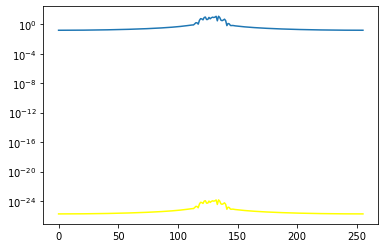

In [41]:
plt.semilogy(np.abs(S_tilde[0,0,:]))
plt.semilogy(np.abs(S[0,:,0]),color='yellow')

#### Ajout de bruit au signal

In [42]:
S_canalXYZ=S_tilde  # donnée non bruitée

In [43]:
noise=[[np.random.normal(0,1,S_tilde.shape[2])+ 1j* np.random.normal(0,1,S_tilde.shape[2]) for _ in range(S_tilde.shape[1])]for _ in range(S_tilde.shape[0])]

In [44]:
n=np.array(noise)

In [45]:
n.shape

(2000, 3, 256)

In [46]:
S_tilde_noise=S_tilde+ n

In [47]:
S_canalXYZ[0,0,0]

(0.14705761869747142+0.06482113041400449j)

Text(0.5, 1.0, 'SNR =10.111804 ')

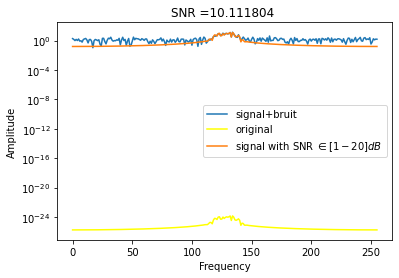

In [48]:
#plt.figure(figsize=(10,8))
plt.semilogy(np.abs(S_tilde_noise[0,0,:]),label='signal+bruit')
plt.semilogy(np.abs(S[0,:,0]),color='yellow',label='original')
plt.semilogy(np.abs(S_tilde[0,0,:]),label=r'signal with SNR $\in [1-20]dB$ ')
plt.ylabel("Amplitude")
plt.xlabel("Frequency")
#plt.semilogy(np.abs(S_tilde_noise[0,0,:]),color='red',label='noise')
plt.legend()
plt.title(r'SNR =%lf '%(X[0,0]),)

###  1. Split data

In [49]:
# we can use par or final_data to do the splitting
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(S_canalXYZ,par,test_size=0.20,random_state=42)

In [50]:
X_train.shape

(1600, 3, 256)

In [51]:
X_train[0,:,0]

array([-0.11950381+0.00163866j,  0.0893227 -0.01559441j,
        0.03029777+0.0147607j ])

In [52]:
X_trainR=np.real(X_train[:,:,:]) # 1600 échantillons 
X_trainI=np.imag(X_train[:,:,:])# 1600 échantillons 
X_Tr=np.concatenate((X_trainR,X_trainI),axis=1)



In [53]:
X_testR=np.real(X_test[:,:,:]) # 400 échantillons 
X_testI=np.imag(X_test[:,:,:])# 400 échantillons 
X_Te=np.concatenate((X_testR,X_testI),axis=1)

X_Te.shape

(400, 6, 256)

In [54]:
Y_test.shape

(400, 3)

In [55]:
X_Tr[0,:,0]

array([-0.11950381,  0.0893227 ,  0.03029777,  0.00163866, -0.01559441,
        0.0147607 ])

In [56]:
X_Tr.shape

(1600, 6, 256)

In [57]:
Y_train.shape

(1600, 3)

In [58]:
X_Tr[0:1,:,:].shape

(1, 6, 256)

###  2. Architecture réseau

####  a. Initialisation des paramètres du réseau (Hyperparamètres)

- Les paramètres du réseau sont spécifiés par une liste python de longueur $N_{\rm layers}$.
- Chaque élément de la liste est un tuple à deux éléments stokant les paramètres des $n_{\rm i}$ neurones de la couche $i^{\rm th}$.
  - Le premier élément de tuple donne des valeurs de paramètres sur les poids $w_{\rm i,i-1}$ , stockés comme un ndarray de la forme ($n_{\rm i}$,$n_{\rm i-1}$).
  - Le deuxième élément de tuple donne des valeurs de paramètres sur les biais $b_{\rm i}$, stokés comme un ndarray de la forme ($n_{\rm i}$, ).

In [59]:
from jax.nn.initializers import glorot_normal,normal
def initialize_network_layer(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys=jax_ran.split(key,len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_network_params(m, n,key):
        w_key,b_key=jax_ran.split(key)
        w_init=glorot_normal()
        b_init=normal()
        if (m==sizes[0]).any():
            ran_weigths=w_init(w_key,(n[0,0],n[0,0],m.shape[0],m.shape[1]))
            ran_biases=b_init(b_key,(n[0,0],n[0,0]))
        elif n==sizes[-1]:
        
            ran_weigths=w_init(w_key,(n,m[0,0],m[0,0]))
            ran_biases=b_init(b_key,(n,))
        else:
            ran_weigths=w_init(w_key,(n[0,0],n[0,0],m[0,0],m[0,0]))
            ran_biases=b_init(b_key,(n[0,0],n[0,0]))
        return ran_weigths,ran_biases
    
    return [initialize_network_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]



####  b. Construction du réseau de neurone

In [60]:
def network_layer_sizes(n_features,n_targets,n_layers,n_neurons_per_layer):
    dense_layer_sizes=[np.asarray(n_neurons_per_layer).reshape(-1,1)]*n_layers
    layer_sizes=[n_features,*dense_layer_sizes,n_targets]
    return layer_sizes



key=jax_ran.PRNGKey(0)
num_features, num_targets =X_Tr[0,:,:], 3          
num_layers, num_neurons_per_layer = 3, 10   # MLP à 3  couches cachées (10 units )

layer_sizes =network_layer_sizes(
   num_features, num_targets, num_layers, num_neurons_per_layer)


# Return a list of tuples of layer weights
params=initialize_network_layer(layer_sizes ,key)
layer_sizes 

[array([[-0.11950381, -0.11935148, -0.11919963, ..., -0.12061275,
         -0.12045877, -0.12030542],
        [ 0.0893227 ,  0.08940591,  0.08948858, ...,  0.08954342,
          0.08962967,  0.08971527],
        [ 0.03029777,  0.03005104,  0.02980541, ...,  0.03122378,
          0.03097211,  0.03072178],
        [ 0.00163866,  0.00017536, -0.00128417, ...,  0.00616599,
          0.00468048,  0.00320016],
        [-0.01559441, -0.01446496, -0.01333794, ..., -0.01916129,
         -0.01801626, -0.01687474],
        [ 0.0147607 ,  0.0150938 ,  0.01542555, ...,  0.01380737,
          0.0141472 ,  0.01448534]]),
 array([[10]]),
 array([[10]]),
 array([[10]]),
 3]

In [61]:
len(params)

4

In [62]:
for w,b in params[:-1]:
    print(w.shape,b.shape)

(10, 10, 6, 256) (10, 10)
(10, 10, 10, 10) (10, 10)
(10, 10, 10, 10) (10, 10)


In [63]:
W,B = params[-1]
print(W.shape,B.shape)

(3, 10, 10) (3,)


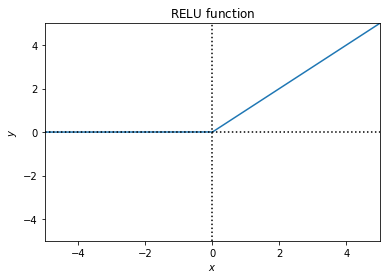

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
from jax.nn import relu

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-5, 5)
ylim = ax.set_ylim(-5, 5)
_x = np.linspace(-5, 5, 1000)
__=ax.plot(_x, relu(_x))
xlabel = ax.set_xlabel(r'$x$')
ylabel = ax.set_ylabel(r'$y$')
title = ax.set_title(r'${\rm RELU\ function}$')
__=ax.plot(_x, np.zeros_like(_x), ':', color='k')
__=ax.plot(np.zeros_like(_x), _x, ':', color='k')

###  3. Feedforward function 

In [65]:
def predict(params,in_array):
    """ Chaque neurone est appliqué à la fonction d'activation y=w*x+b,
     seulement la dernière couche (couche de sortie) qui n'utilise pas de cette fonction d'activation (régression) 
     utilisation de la fonction identité
     
     Paramètres de la fonction:
     --------------------------------
       params: list de tuple 
            paramètre du réseau , avec une liste d'élément par couche (w,b)
       in_array: ndarray 
            shape de la forme (batch_size, n_features)
    
     Returns
     -------------------------------
        preds: ndarray
             ndarray dont le shape est (batch_size, n_targets)
     
     """
    
    activations = in_array
    
    # Boucle itérative sur chaque couche dense exceptée la dernière
    
    for w, b in params[:-1]:
        outputs = jax_np.einsum('mjt,ikjt ->mik',activations,w)+b[np.newaxis,:,:]  # Application de la transformation linéaire
        activations = relu(outputs)  #  apply nonlinear activation
        
    #  Now for the final layer
    w_final, b_final = params[-1] 
    final_outputs = jax_np.einsum('mik,sik ->ms',activations,w_final) + b_final[np.newaxis,:] 
    return final_outputs  # Final layer is just w*x + b with no activation

In [232]:
pred=predict(params,X_Tr)

In [233]:
pred.shape

(1600, 3)

###  4. Loss function

In [234]:
def mse_loss(params, in_array, targets):
    pred = predict(params,in_array)
    diff_Ampli = [(pred[i,0]-targets[i,0])**2/pred.shape[0] for i in range(pred.shape[0])]
    diff_Beta = [(pred[j,1]-targets[j,1])**2/pred.shape[0] for j in range(pred.shape[0])]
    diff_lambda = [(pred[k,2]-targets[k,2])**2/pred.shape[0] for k in range(pred.shape[0])]
    error=sum(diff_Ampli) +sum(diff_Beta)+sum(diff_lambda)
    return error

In [235]:
mse_loss(params, X_Tr, Y_train)

DeviceArray(0.73782897, dtype=float32)

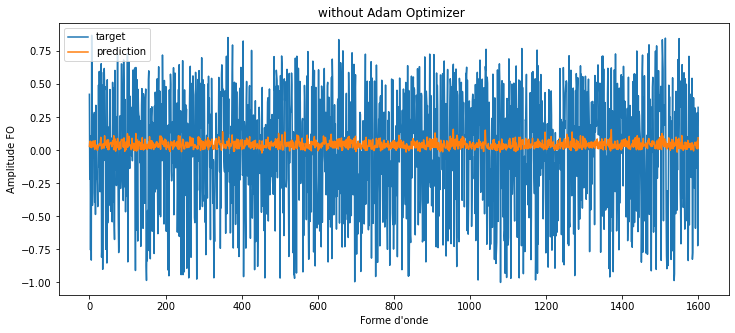

In [237]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,0],label='target')
plt.plot(pred[:,0],label='prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.title('without Adam Optimizer ')
plt.legend()

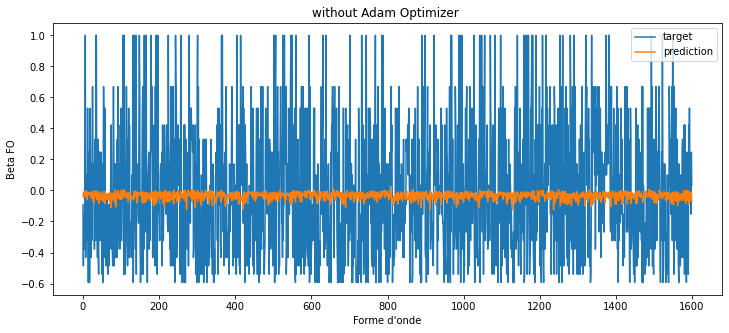

In [238]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,1],label='target')
plt.plot(pred[:,1],label='prediction')
plt.ylabel('Beta FO')
plt.xlabel("Forme d'onde")
plt.title('without Adam Optimizer ')
plt.legend()

### 5. Backpropagation 

In [203]:
num_epochs =1000
batch_size=200
num_batches=8

In [204]:

# Defining an optimizer in Jax
learning_rate= 1e-3
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params) # init avce les paramètre du réseau

# Define a compiled update step
@jax_jit
def update(i, opt_state, x, y):
    p = get_params(opt_state)
    g = jax_grad(mse_loss)(p, x, y)
    loss=mse_loss(p,x,y)
    return opt_update(i, g, opt_state),loss





###  6. Training Loop 

In [169]:
from jax import lax
@jax_jit
def run_epoch(opt_state,X_train,Y_train):
    
    def batch_opt(i, opt_state):
        #Los=[]
        j = i // num_batches
        batch_x = lax.dynamic_slice_in_dim(X_train, j * batch_size, batch_size)
        batch_y = lax.dynamic_slice_in_dim(Y_train, j * batch_size, batch_size)
    #  fonction définissant la loss à minimiser, son gradient g pour l'état opt_state de la minimisation
        loss = lambda params: mse_loss(params, batch_x, batch_y)
        g = jax_grad(loss)(get_params(opt_state))
        return opt_update(i, g, opt_state)
    return lax.fori_loop(0, num_batches, batch_opt, opt_state) #num_batches est le nb de batches et batch_size leur taille
# en sortie, opt_state pour une époque

In [147]:
net_params=get_params(opt)

In [205]:
import time
def run_func(opt_state,X_train,Y_train):
    Los=[]
# Adam optimisation
    start_time = time.time()
    for epoch in range(num_epochs):
        for batch_idx in range(num_batches):
            j = epoch // num_batches
            batch_x = lax.dynamic_slice_in_dim(X_train, j * batch_size, batch_size)
            batch_y = lax.dynamic_slice_in_dim(Y_train, j * batch_size, batch_size)
            opt_state ,loss = update(epoch, opt_state,batch_x,batch_y)
            batch_time = time.time() - start_time
            Los.append(loss)
            print("Batch {} | T: {:0.2f} | MSE: {:0.2f} |".format(batch_idx, batch_time, loss))
    return get_params(opt_state),Los
#net_params = get_params(opt_state)

In [206]:
net_params,Loss=run_func(opt_state,X_Tr,Y_train)

Batch 0 | T: 0.02 | MSE: 0.72 |
Batch 1 | T: 0.04 | MSE: 0.64 |
Batch 2 | T: 0.06 | MSE: 0.57 |
Batch 3 | T: 0.07 | MSE: 0.48 |
Batch 4 | T: 0.09 | MSE: 0.38 |
Batch 5 | T: 0.11 | MSE: 0.33 |
Batch 6 | T: 0.12 | MSE: 0.30 |
Batch 7 | T: 0.14 | MSE: 0.28 |
Batch 0 | T: 0.15 | MSE: 0.25 |
Batch 1 | T: 0.17 | MSE: 0.24 |
Batch 2 | T: 0.19 | MSE: 0.22 |
Batch 3 | T: 0.20 | MSE: 0.21 |
Batch 4 | T: 0.22 | MSE: 0.20 |
Batch 5 | T: 0.25 | MSE: 0.19 |
Batch 6 | T: 0.27 | MSE: 0.18 |
Batch 7 | T: 0.31 | MSE: 0.18 |
Batch 0 | T: 0.34 | MSE: 0.17 |
Batch 1 | T: 0.36 | MSE: 0.16 |
Batch 2 | T: 0.38 | MSE: 0.16 |
Batch 3 | T: 0.39 | MSE: 0.15 |
Batch 4 | T: 0.41 | MSE: 0.15 |
Batch 5 | T: 0.42 | MSE: 0.14 |
Batch 6 | T: 0.43 | MSE: 0.14 |
Batch 7 | T: 0.45 | MSE: 0.13 |
Batch 0 | T: 0.46 | MSE: 0.13 |
Batch 1 | T: 0.47 | MSE: 0.13 |
Batch 2 | T: 0.49 | MSE: 0.12 |
Batch 3 | T: 0.51 | MSE: 0.12 |
Batch 4 | T: 0.53 | MSE: 0.11 |
Batch 5 | T: 0.55 | MSE: 0.11 |
Batch 6 | T: 0.56 | MSE: 0.11 |
Batch 7 

Batch 2 | T: 5.27 | MSE: 0.17 |
Batch 3 | T: 5.30 | MSE: 0.15 |
Batch 4 | T: 5.34 | MSE: 0.14 |
Batch 5 | T: 5.36 | MSE: 0.13 |
Batch 6 | T: 5.37 | MSE: 0.12 |
Batch 7 | T: 5.38 | MSE: 0.12 |
Batch 0 | T: 5.40 | MSE: 0.11 |
Batch 1 | T: 5.41 | MSE: 0.11 |
Batch 2 | T: 5.42 | MSE: 0.10 |
Batch 3 | T: 5.44 | MSE: 0.10 |
Batch 4 | T: 5.45 | MSE: 0.09 |
Batch 5 | T: 5.46 | MSE: 0.09 |
Batch 6 | T: 5.48 | MSE: 0.09 |
Batch 7 | T: 5.49 | MSE: 0.09 |
Batch 0 | T: 5.51 | MSE: 0.08 |
Batch 1 | T: 5.53 | MSE: 0.08 |
Batch 2 | T: 5.54 | MSE: 0.08 |
Batch 3 | T: 5.55 | MSE: 0.08 |
Batch 4 | T: 5.57 | MSE: 0.08 |
Batch 5 | T: 5.58 | MSE: 0.07 |
Batch 6 | T: 5.60 | MSE: 0.07 |
Batch 7 | T: 5.61 | MSE: 0.07 |
Batch 0 | T: 5.62 | MSE: 0.07 |
Batch 1 | T: 5.63 | MSE: 0.07 |
Batch 2 | T: 5.65 | MSE: 0.07 |
Batch 3 | T: 5.66 | MSE: 0.07 |
Batch 4 | T: 5.67 | MSE: 0.07 |
Batch 5 | T: 5.69 | MSE: 0.07 |
Batch 6 | T: 5.70 | MSE: 0.06 |
Batch 7 | T: 5.72 | MSE: 0.06 |
Batch 0 | T: 5.74 | MSE: 0.06 |
Batch 1 

Batch 2 | T: 11.04 | MSE: 0.07 |
Batch 3 | T: 11.09 | MSE: 0.07 |
Batch 4 | T: 11.17 | MSE: 0.07 |
Batch 5 | T: 11.20 | MSE: 0.07 |
Batch 6 | T: 11.23 | MSE: 0.07 |
Batch 7 | T: 11.30 | MSE: 0.07 |
Batch 0 | T: 11.36 | MSE: 0.07 |
Batch 1 | T: 11.41 | MSE: 0.07 |
Batch 2 | T: 11.42 | MSE: 0.07 |
Batch 3 | T: 11.45 | MSE: 0.07 |
Batch 4 | T: 11.49 | MSE: 0.07 |
Batch 5 | T: 11.51 | MSE: 0.07 |
Batch 6 | T: 11.54 | MSE: 0.07 |
Batch 7 | T: 11.56 | MSE: 0.07 |
Batch 0 | T: 11.58 | MSE: 0.07 |
Batch 1 | T: 11.60 | MSE: 0.07 |
Batch 2 | T: 11.63 | MSE: 0.07 |
Batch 3 | T: 11.66 | MSE: 0.07 |
Batch 4 | T: 11.67 | MSE: 0.07 |
Batch 5 | T: 11.69 | MSE: 0.07 |
Batch 6 | T: 11.70 | MSE: 0.07 |
Batch 7 | T: 11.72 | MSE: 0.07 |
Batch 0 | T: 11.75 | MSE: 0.07 |
Batch 1 | T: 11.76 | MSE: 0.07 |
Batch 2 | T: 11.78 | MSE: 0.07 |
Batch 3 | T: 11.80 | MSE: 0.07 |
Batch 4 | T: 11.81 | MSE: 0.07 |
Batch 5 | T: 11.83 | MSE: 0.07 |
Batch 6 | T: 11.85 | MSE: 0.07 |
Batch 7 | T: 11.86 | MSE: 0.07 |
Batch 0 | 

Batch 1 | T: 18.97 | MSE: 0.05 |
Batch 2 | T: 18.99 | MSE: 0.05 |
Batch 3 | T: 19.00 | MSE: 0.05 |
Batch 4 | T: 19.02 | MSE: 0.05 |
Batch 5 | T: 19.04 | MSE: 0.05 |
Batch 6 | T: 19.05 | MSE: 0.05 |
Batch 7 | T: 19.07 | MSE: 0.05 |
Batch 0 | T: 19.09 | MSE: 0.05 |
Batch 1 | T: 19.12 | MSE: 0.05 |
Batch 2 | T: 19.21 | MSE: 0.05 |
Batch 3 | T: 19.25 | MSE: 0.05 |
Batch 4 | T: 19.29 | MSE: 0.05 |
Batch 5 | T: 19.34 | MSE: 0.05 |
Batch 6 | T: 19.37 | MSE: 0.05 |
Batch 7 | T: 19.43 | MSE: 0.05 |
Batch 0 | T: 19.48 | MSE: 0.05 |
Batch 1 | T: 19.51 | MSE: 0.05 |
Batch 2 | T: 19.53 | MSE: 0.04 |
Batch 3 | T: 19.56 | MSE: 0.05 |
Batch 4 | T: 19.59 | MSE: 0.05 |
Batch 5 | T: 19.63 | MSE: 0.05 |
Batch 6 | T: 19.65 | MSE: 0.05 |
Batch 7 | T: 19.67 | MSE: 0.04 |
Batch 0 | T: 19.70 | MSE: 0.04 |
Batch 1 | T: 19.74 | MSE: 0.04 |
Batch 2 | T: 19.78 | MSE: 0.05 |
Batch 3 | T: 19.81 | MSE: 0.05 |
Batch 4 | T: 19.85 | MSE: 0.04 |
Batch 5 | T: 19.86 | MSE: 0.04 |
Batch 6 | T: 19.91 | MSE: 0.04 |
Batch 7 | 

Batch 7 | T: 27.53 | MSE: 0.04 |
Batch 0 | T: 27.56 | MSE: 0.04 |
Batch 1 | T: 27.59 | MSE: 0.04 |
Batch 2 | T: 27.64 | MSE: 0.03 |
Batch 3 | T: 27.67 | MSE: 0.04 |
Batch 4 | T: 27.71 | MSE: 0.04 |
Batch 5 | T: 27.74 | MSE: 0.04 |
Batch 6 | T: 27.78 | MSE: 0.04 |
Batch 7 | T: 27.81 | MSE: 0.03 |
Batch 0 | T: 27.85 | MSE: 0.03 |
Batch 1 | T: 27.86 | MSE: 0.04 |
Batch 2 | T: 27.91 | MSE: 0.03 |
Batch 3 | T: 27.93 | MSE: 0.03 |
Batch 4 | T: 27.95 | MSE: 0.03 |
Batch 5 | T: 27.96 | MSE: 0.03 |
Batch 6 | T: 27.98 | MSE: 0.03 |
Batch 7 | T: 28.00 | MSE: 0.03 |
Batch 0 | T: 28.06 | MSE: 0.03 |
Batch 1 | T: 28.12 | MSE: 0.03 |
Batch 2 | T: 28.15 | MSE: 0.03 |
Batch 3 | T: 28.19 | MSE: 0.03 |
Batch 4 | T: 28.26 | MSE: 0.03 |
Batch 5 | T: 28.29 | MSE: 0.03 |
Batch 6 | T: 28.32 | MSE: 0.03 |
Batch 7 | T: 28.38 | MSE: 0.03 |
Batch 0 | T: 28.41 | MSE: 0.03 |
Batch 1 | T: 28.45 | MSE: 0.03 |
Batch 2 | T: 28.49 | MSE: 0.03 |
Batch 3 | T: 28.53 | MSE: 0.03 |
Batch 4 | T: 28.55 | MSE: 0.03 |
Batch 5 | 

Batch 7 | T: 36.72 | MSE: 0.02 |
Batch 0 | T: 36.75 | MSE: 0.02 |
Batch 1 | T: 36.78 | MSE: 0.02 |
Batch 2 | T: 36.83 | MSE: 0.02 |
Batch 3 | T: 36.88 | MSE: 0.02 |
Batch 4 | T: 36.91 | MSE: 0.02 |
Batch 5 | T: 36.94 | MSE: 0.02 |
Batch 6 | T: 36.98 | MSE: 0.02 |
Batch 7 | T: 37.05 | MSE: 0.02 |
Batch 0 | T: 37.10 | MSE: 0.02 |
Batch 1 | T: 37.13 | MSE: 0.02 |
Batch 2 | T: 37.18 | MSE: 0.02 |
Batch 3 | T: 37.26 | MSE: 0.02 |
Batch 4 | T: 37.30 | MSE: 0.02 |
Batch 5 | T: 37.35 | MSE: 0.02 |
Batch 6 | T: 37.37 | MSE: 0.02 |
Batch 7 | T: 37.41 | MSE: 0.02 |
Batch 0 | T: 37.44 | MSE: 0.02 |
Batch 1 | T: 37.50 | MSE: 0.02 |
Batch 2 | T: 37.54 | MSE: 0.02 |
Batch 3 | T: 37.57 | MSE: 0.02 |
Batch 4 | T: 37.63 | MSE: 0.02 |
Batch 5 | T: 37.67 | MSE: 0.02 |
Batch 6 | T: 37.71 | MSE: 0.02 |
Batch 7 | T: 37.75 | MSE: 0.02 |
Batch 0 | T: 37.80 | MSE: 0.02 |
Batch 1 | T: 37.83 | MSE: 0.02 |
Batch 2 | T: 37.93 | MSE: 0.02 |
Batch 3 | T: 37.98 | MSE: 0.02 |
Batch 4 | T: 38.04 | MSE: 0.02 |
Batch 5 | 

Batch 1 | T: 44.84 | MSE: 0.02 |
Batch 2 | T: 44.86 | MSE: 0.02 |
Batch 3 | T: 44.91 | MSE: 0.02 |
Batch 4 | T: 44.97 | MSE: 0.02 |
Batch 5 | T: 44.99 | MSE: 0.02 |
Batch 6 | T: 45.01 | MSE: 0.02 |
Batch 7 | T: 45.06 | MSE: 0.02 |
Batch 0 | T: 45.11 | MSE: 0.02 |
Batch 1 | T: 45.15 | MSE: 0.02 |
Batch 2 | T: 45.17 | MSE: 0.02 |
Batch 3 | T: 45.18 | MSE: 0.02 |
Batch 4 | T: 45.20 | MSE: 0.02 |
Batch 5 | T: 45.23 | MSE: 0.02 |
Batch 6 | T: 45.27 | MSE: 0.02 |
Batch 7 | T: 45.36 | MSE: 0.02 |
Batch 0 | T: 45.40 | MSE: 0.02 |
Batch 1 | T: 45.46 | MSE: 0.02 |
Batch 2 | T: 45.49 | MSE: 0.02 |
Batch 3 | T: 45.52 | MSE: 0.02 |
Batch 4 | T: 45.55 | MSE: 0.02 |
Batch 5 | T: 45.57 | MSE: 0.02 |
Batch 6 | T: 45.64 | MSE: 0.02 |
Batch 7 | T: 45.68 | MSE: 0.02 |
Batch 0 | T: 45.72 | MSE: 0.02 |
Batch 1 | T: 45.77 | MSE: 0.02 |
Batch 2 | T: 45.80 | MSE: 0.02 |
Batch 3 | T: 45.82 | MSE: 0.02 |
Batch 4 | T: 45.84 | MSE: 0.02 |
Batch 5 | T: 45.85 | MSE: 0.02 |
Batch 6 | T: 45.87 | MSE: 0.02 |
Batch 7 | 

Batch 3 | T: 52.34 | MSE: 0.02 |
Batch 4 | T: 52.37 | MSE: 0.02 |
Batch 5 | T: 52.46 | MSE: 0.02 |
Batch 6 | T: 52.53 | MSE: 0.02 |
Batch 7 | T: 52.62 | MSE: 0.02 |
Batch 0 | T: 52.68 | MSE: 0.02 |
Batch 1 | T: 52.71 | MSE: 0.02 |
Batch 2 | T: 52.82 | MSE: 0.02 |
Batch 3 | T: 52.87 | MSE: 0.02 |
Batch 4 | T: 52.92 | MSE: 0.01 |
Batch 5 | T: 52.95 | MSE: 0.01 |
Batch 6 | T: 53.02 | MSE: 0.01 |
Batch 7 | T: 53.08 | MSE: 0.02 |
Batch 0 | T: 53.12 | MSE: 0.02 |
Batch 1 | T: 53.14 | MSE: 0.02 |
Batch 2 | T: 53.17 | MSE: 0.02 |
Batch 3 | T: 53.19 | MSE: 0.02 |
Batch 4 | T: 53.20 | MSE: 0.02 |
Batch 5 | T: 53.22 | MSE: 0.02 |
Batch 6 | T: 53.24 | MSE: 0.02 |
Batch 7 | T: 53.25 | MSE: 0.02 |
Batch 0 | T: 53.27 | MSE: 0.02 |
Batch 1 | T: 53.30 | MSE: 0.02 |
Batch 2 | T: 53.32 | MSE: 0.01 |
Batch 3 | T: 53.35 | MSE: 0.02 |
Batch 4 | T: 53.37 | MSE: 0.02 |
Batch 5 | T: 53.39 | MSE: 0.02 |
Batch 6 | T: 53.40 | MSE: 0.02 |
Batch 7 | T: 53.42 | MSE: 0.02 |
Batch 0 | T: 53.44 | MSE: 0.02 |
Batch 1 | 

Batch 6 | T: 59.22 | MSE: 0.01 |
Batch 7 | T: 59.24 | MSE: 0.01 |
Batch 0 | T: 59.27 | MSE: 0.01 |
Batch 1 | T: 59.31 | MSE: 0.01 |
Batch 2 | T: 59.34 | MSE: 0.01 |
Batch 3 | T: 59.36 | MSE: 0.01 |
Batch 4 | T: 59.39 | MSE: 0.01 |
Batch 5 | T: 59.43 | MSE: 0.01 |
Batch 6 | T: 59.48 | MSE: 0.01 |
Batch 7 | T: 59.52 | MSE: 0.01 |
Batch 0 | T: 59.56 | MSE: 0.01 |
Batch 1 | T: 59.61 | MSE: 0.01 |
Batch 2 | T: 59.63 | MSE: 0.01 |
Batch 3 | T: 59.68 | MSE: 0.01 |
Batch 4 | T: 59.74 | MSE: 0.01 |
Batch 5 | T: 59.78 | MSE: 0.01 |
Batch 6 | T: 59.79 | MSE: 0.01 |
Batch 7 | T: 59.81 | MSE: 0.01 |
Batch 0 | T: 59.82 | MSE: 0.01 |
Batch 1 | T: 59.84 | MSE: 0.01 |
Batch 2 | T: 59.85 | MSE: 0.01 |
Batch 3 | T: 59.88 | MSE: 0.01 |
Batch 4 | T: 59.93 | MSE: 0.01 |
Batch 5 | T: 59.96 | MSE: 0.01 |
Batch 6 | T: 60.02 | MSE: 0.01 |
Batch 7 | T: 60.08 | MSE: 0.01 |
Batch 0 | T: 60.11 | MSE: 0.01 |
Batch 1 | T: 60.16 | MSE: 0.01 |
Batch 2 | T: 60.21 | MSE: 0.01 |
Batch 3 | T: 60.23 | MSE: 0.01 |
Batch 4 | 

Batch 7 | T: 67.36 | MSE: 0.01 |
Batch 0 | T: 67.42 | MSE: 0.01 |
Batch 1 | T: 67.46 | MSE: 0.01 |
Batch 2 | T: 67.50 | MSE: 0.01 |
Batch 3 | T: 67.53 | MSE: 0.01 |
Batch 4 | T: 67.55 | MSE: 0.01 |
Batch 5 | T: 67.60 | MSE: 0.01 |
Batch 6 | T: 67.63 | MSE: 0.01 |
Batch 7 | T: 67.65 | MSE: 0.01 |
Batch 0 | T: 67.66 | MSE: 0.01 |
Batch 1 | T: 67.67 | MSE: 0.01 |
Batch 2 | T: 67.69 | MSE: 0.01 |
Batch 3 | T: 67.72 | MSE: 0.01 |
Batch 4 | T: 67.74 | MSE: 0.01 |
Batch 5 | T: 67.79 | MSE: 0.01 |
Batch 6 | T: 67.82 | MSE: 0.01 |
Batch 7 | T: 67.84 | MSE: 0.01 |
Batch 0 | T: 67.89 | MSE: 0.01 |
Batch 1 | T: 67.94 | MSE: 0.01 |
Batch 2 | T: 67.98 | MSE: 0.01 |
Batch 3 | T: 68.02 | MSE: 0.01 |
Batch 4 | T: 68.05 | MSE: 0.01 |
Batch 5 | T: 68.11 | MSE: 0.01 |
Batch 6 | T: 68.14 | MSE: 0.01 |
Batch 7 | T: 68.17 | MSE: 0.01 |
Batch 0 | T: 68.21 | MSE: 0.01 |
Batch 1 | T: 68.23 | MSE: 0.01 |
Batch 2 | T: 68.26 | MSE: 0.01 |
Batch 3 | T: 68.28 | MSE: 0.01 |
Batch 4 | T: 68.30 | MSE: 0.01 |
Batch 5 | 

Batch 3 | T: 75.44 | MSE: 0.01 |
Batch 4 | T: 75.46 | MSE: 0.01 |
Batch 5 | T: 75.49 | MSE: 0.01 |
Batch 6 | T: 75.52 | MSE: 0.01 |
Batch 7 | T: 75.57 | MSE: 0.01 |
Batch 0 | T: 75.61 | MSE: 0.01 |
Batch 1 | T: 75.64 | MSE: 0.01 |
Batch 2 | T: 75.69 | MSE: 0.01 |
Batch 3 | T: 75.73 | MSE: 0.01 |
Batch 4 | T: 75.79 | MSE: 0.01 |
Batch 5 | T: 75.85 | MSE: 0.01 |
Batch 6 | T: 75.89 | MSE: 0.01 |
Batch 7 | T: 75.92 | MSE: 0.01 |
Batch 0 | T: 75.95 | MSE: 0.01 |
Batch 1 | T: 76.01 | MSE: 0.01 |
Batch 2 | T: 76.04 | MSE: 0.01 |
Batch 3 | T: 76.05 | MSE: 0.01 |
Batch 4 | T: 76.07 | MSE: 0.01 |
Batch 5 | T: 76.08 | MSE: 0.01 |
Batch 6 | T: 76.10 | MSE: 0.01 |
Batch 7 | T: 76.12 | MSE: 0.01 |
Batch 0 | T: 76.16 | MSE: 0.01 |
Batch 1 | T: 76.18 | MSE: 0.01 |
Batch 2 | T: 76.24 | MSE: 0.01 |
Batch 3 | T: 76.27 | MSE: 0.02 |
Batch 4 | T: 76.31 | MSE: 0.01 |
Batch 5 | T: 76.35 | MSE: 0.01 |
Batch 6 | T: 76.37 | MSE: 0.01 |
Batch 7 | T: 76.41 | MSE: 0.01 |
Batch 0 | T: 76.44 | MSE: 0.01 |
Batch 1 | 

Batch 5 | T: 83.70 | MSE: 0.01 |
Batch 6 | T: 83.74 | MSE: 0.01 |
Batch 7 | T: 83.78 | MSE: 0.01 |
Batch 0 | T: 83.81 | MSE: 0.01 |
Batch 1 | T: 83.85 | MSE: 0.01 |
Batch 2 | T: 83.90 | MSE: 0.01 |
Batch 3 | T: 83.94 | MSE: 0.01 |
Batch 4 | T: 84.00 | MSE: 0.01 |
Batch 5 | T: 84.05 | MSE: 0.01 |
Batch 6 | T: 84.08 | MSE: 0.01 |
Batch 7 | T: 84.12 | MSE: 0.01 |
Batch 0 | T: 84.14 | MSE: 0.01 |
Batch 1 | T: 84.15 | MSE: 0.01 |
Batch 2 | T: 84.17 | MSE: 0.01 |
Batch 3 | T: 84.19 | MSE: 0.01 |
Batch 4 | T: 84.22 | MSE: 0.01 |
Batch 5 | T: 84.25 | MSE: 0.01 |
Batch 6 | T: 84.29 | MSE: 0.01 |
Batch 7 | T: 84.34 | MSE: 0.01 |
Batch 0 | T: 84.38 | MSE: 0.01 |
Batch 1 | T: 84.42 | MSE: 0.01 |
Batch 2 | T: 84.45 | MSE: 0.01 |
Batch 3 | T: 84.48 | MSE: 0.01 |
Batch 4 | T: 84.50 | MSE: 0.02 |
Batch 5 | T: 84.53 | MSE: 0.01 |
Batch 6 | T: 84.54 | MSE: 0.01 |
Batch 7 | T: 84.58 | MSE: 0.01 |
Batch 0 | T: 84.61 | MSE: 0.01 |
Batch 1 | T: 84.66 | MSE: 0.01 |
Batch 2 | T: 84.76 | MSE: 0.01 |
Batch 3 | 

Batch 0 | T: 90.65 | MSE: 0.01 |
Batch 1 | T: 90.67 | MSE: 0.01 |
Batch 2 | T: 90.70 | MSE: 0.01 |
Batch 3 | T: 90.76 | MSE: 0.01 |
Batch 4 | T: 90.79 | MSE: 0.01 |
Batch 5 | T: 90.82 | MSE: 0.01 |
Batch 6 | T: 90.85 | MSE: 0.01 |
Batch 7 | T: 90.91 | MSE: 0.01 |
Batch 0 | T: 90.93 | MSE: 0.01 |
Batch 1 | T: 90.96 | MSE: 0.01 |
Batch 2 | T: 90.99 | MSE: 0.01 |
Batch 3 | T: 91.01 | MSE: 0.01 |
Batch 4 | T: 91.02 | MSE: 0.01 |
Batch 5 | T: 91.04 | MSE: 0.01 |
Batch 6 | T: 91.06 | MSE: 0.01 |
Batch 7 | T: 91.10 | MSE: 0.01 |
Batch 0 | T: 91.14 | MSE: 0.01 |
Batch 1 | T: 91.17 | MSE: 0.01 |
Batch 2 | T: 91.19 | MSE: 0.01 |
Batch 3 | T: 91.22 | MSE: 0.01 |
Batch 4 | T: 91.26 | MSE: 0.01 |
Batch 5 | T: 91.28 | MSE: 0.01 |
Batch 6 | T: 91.29 | MSE: 0.01 |
Batch 7 | T: 91.31 | MSE: 0.01 |
Batch 0 | T: 91.33 | MSE: 0.01 |
Batch 1 | T: 91.35 | MSE: 0.01 |
Batch 2 | T: 91.36 | MSE: 0.01 |
Batch 3 | T: 91.38 | MSE: 0.01 |
Batch 4 | T: 91.40 | MSE: 0.01 |
Batch 5 | T: 91.41 | MSE: 0.01 |
Batch 6 | 

Batch 5 | T: 95.16 | MSE: 0.01 |
Batch 6 | T: 95.18 | MSE: 0.01 |
Batch 7 | T: 95.21 | MSE: 0.01 |
Batch 0 | T: 95.25 | MSE: 0.01 |
Batch 1 | T: 95.28 | MSE: 0.01 |
Batch 2 | T: 95.30 | MSE: 0.01 |
Batch 3 | T: 95.34 | MSE: 0.01 |
Batch 4 | T: 95.37 | MSE: 0.01 |
Batch 5 | T: 95.40 | MSE: 0.01 |
Batch 6 | T: 95.43 | MSE: 0.01 |
Batch 7 | T: 95.45 | MSE: 0.01 |
Batch 0 | T: 95.49 | MSE: 0.01 |
Batch 1 | T: 95.52 | MSE: 0.01 |
Batch 2 | T: 95.55 | MSE: 0.01 |
Batch 3 | T: 95.60 | MSE: 0.02 |
Batch 4 | T: 95.63 | MSE: 0.02 |
Batch 5 | T: 95.65 | MSE: 0.01 |
Batch 6 | T: 95.68 | MSE: 0.01 |
Batch 7 | T: 95.73 | MSE: 0.01 |
Batch 0 | T: 95.76 | MSE: 0.01 |
Batch 1 | T: 95.79 | MSE: 0.01 |
Batch 2 | T: 95.83 | MSE: 0.01 |
Batch 3 | T: 95.86 | MSE: 0.01 |
Batch 4 | T: 95.87 | MSE: 0.01 |
Batch 5 | T: 95.91 | MSE: 0.01 |
Batch 6 | T: 95.95 | MSE: 0.01 |
Batch 7 | T: 95.98 | MSE: 0.01 |
Batch 0 | T: 96.03 | MSE: 0.01 |
Batch 1 | T: 96.08 | MSE: 0.01 |
Batch 2 | T: 96.09 | MSE: 0.01 |
Batch 3 | 

Batch 3 | T: 102.91 | MSE: 0.01 |
Batch 4 | T: 102.94 | MSE: 0.01 |
Batch 5 | T: 102.98 | MSE: 0.01 |
Batch 6 | T: 103.02 | MSE: 0.01 |
Batch 7 | T: 103.05 | MSE: 0.01 |
Batch 0 | T: 103.09 | MSE: 0.01 |
Batch 1 | T: 103.12 | MSE: 0.01 |
Batch 2 | T: 103.15 | MSE: 0.01 |
Batch 3 | T: 103.17 | MSE: 0.01 |
Batch 4 | T: 103.19 | MSE: 0.01 |
Batch 5 | T: 103.21 | MSE: 0.01 |
Batch 6 | T: 103.23 | MSE: 0.01 |
Batch 7 | T: 103.24 | MSE: 0.01 |
Batch 0 | T: 103.26 | MSE: 0.01 |
Batch 1 | T: 103.30 | MSE: 0.01 |
Batch 2 | T: 103.33 | MSE: 0.01 |
Batch 3 | T: 103.35 | MSE: 0.01 |
Batch 4 | T: 103.37 | MSE: 0.01 |
Batch 5 | T: 103.40 | MSE: 0.01 |
Batch 6 | T: 103.43 | MSE: 0.01 |
Batch 7 | T: 103.48 | MSE: 0.01 |
Batch 0 | T: 103.50 | MSE: 0.01 |
Batch 1 | T: 103.53 | MSE: 0.01 |
Batch 2 | T: 103.55 | MSE: 0.01 |
Batch 3 | T: 103.58 | MSE: 0.01 |
Batch 4 | T: 103.62 | MSE: 0.01 |
Batch 5 | T: 103.65 | MSE: 0.01 |
Batch 6 | T: 103.69 | MSE: 0.01 |
Batch 7 | T: 103.71 | MSE: 0.01 |
Batch 0 | T: 1

Batch 7 | T: 110.52 | MSE: 0.01 |
Batch 0 | T: 110.57 | MSE: 0.01 |
Batch 1 | T: 110.61 | MSE: 0.01 |
Batch 2 | T: 110.65 | MSE: 0.01 |
Batch 3 | T: 110.68 | MSE: 0.01 |
Batch 4 | T: 110.71 | MSE: 0.01 |
Batch 5 | T: 110.77 | MSE: 0.01 |
Batch 6 | T: 110.80 | MSE: 0.01 |
Batch 7 | T: 110.82 | MSE: 0.01 |
Batch 0 | T: 110.84 | MSE: 0.01 |
Batch 1 | T: 110.85 | MSE: 0.01 |
Batch 2 | T: 110.87 | MSE: 0.01 |
Batch 3 | T: 110.88 | MSE: 0.01 |
Batch 4 | T: 110.90 | MSE: 0.01 |
Batch 5 | T: 110.91 | MSE: 0.01 |
Batch 6 | T: 110.92 | MSE: 0.01 |
Batch 7 | T: 110.94 | MSE: 0.01 |
Batch 0 | T: 110.95 | MSE: 0.01 |
Batch 1 | T: 110.96 | MSE: 0.01 |
Batch 2 | T: 110.98 | MSE: 0.01 |
Batch 3 | T: 111.00 | MSE: 0.01 |
Batch 4 | T: 111.02 | MSE: 0.01 |
Batch 5 | T: 111.03 | MSE: 0.01 |
Batch 6 | T: 111.05 | MSE: 0.01 |
Batch 7 | T: 111.06 | MSE: 0.01 |
Batch 0 | T: 111.08 | MSE: 0.01 |
Batch 1 | T: 111.09 | MSE: 0.01 |
Batch 2 | T: 111.11 | MSE: 0.01 |
Batch 3 | T: 111.12 | MSE: 0.01 |
Batch 4 | T: 1

Batch 1 | T: 115.79 | MSE: 0.01 |
Batch 2 | T: 115.81 | MSE: 0.01 |
Batch 3 | T: 115.84 | MSE: 0.01 |
Batch 4 | T: 115.86 | MSE: 0.01 |
Batch 5 | T: 115.87 | MSE: 0.01 |
Batch 6 | T: 115.89 | MSE: 0.01 |
Batch 7 | T: 115.90 | MSE: 0.01 |
Batch 0 | T: 115.91 | MSE: 0.01 |
Batch 1 | T: 115.93 | MSE: 0.01 |
Batch 2 | T: 115.94 | MSE: 0.01 |
Batch 3 | T: 115.95 | MSE: 0.01 |
Batch 4 | T: 115.97 | MSE: 0.01 |
Batch 5 | T: 115.98 | MSE: 0.01 |
Batch 6 | T: 116.00 | MSE: 0.01 |
Batch 7 | T: 116.01 | MSE: 0.01 |
Batch 0 | T: 116.03 | MSE: 0.01 |
Batch 1 | T: 116.05 | MSE: 0.01 |
Batch 2 | T: 116.06 | MSE: 0.01 |
Batch 3 | T: 116.08 | MSE: 0.01 |
Batch 4 | T: 116.09 | MSE: 0.01 |
Batch 5 | T: 116.10 | MSE: 0.01 |
Batch 6 | T: 116.12 | MSE: 0.01 |
Batch 7 | T: 116.13 | MSE: 0.01 |
Batch 0 | T: 116.14 | MSE: 0.01 |
Batch 1 | T: 116.16 | MSE: 0.01 |
Batch 2 | T: 116.17 | MSE: 0.01 |
Batch 3 | T: 116.18 | MSE: 0.01 |
Batch 4 | T: 116.20 | MSE: 0.01 |
Batch 5 | T: 116.21 | MSE: 0.01 |
Batch 6 | T: 1

Batch 1 | T: 119.61 | MSE: 0.01 |
Batch 2 | T: 119.63 | MSE: 0.01 |
Batch 3 | T: 119.65 | MSE: 0.01 |
Batch 4 | T: 119.69 | MSE: 0.01 |
Batch 5 | T: 119.73 | MSE: 0.01 |
Batch 6 | T: 119.77 | MSE: 0.01 |
Batch 7 | T: 119.80 | MSE: 0.01 |
Batch 0 | T: 119.83 | MSE: 0.01 |
Batch 1 | T: 119.86 | MSE: 0.01 |
Batch 2 | T: 119.89 | MSE: 0.01 |
Batch 3 | T: 119.94 | MSE: 0.01 |
Batch 4 | T: 119.98 | MSE: 0.01 |
Batch 5 | T: 120.03 | MSE: 0.01 |
Batch 6 | T: 120.07 | MSE: 0.01 |
Batch 7 | T: 120.11 | MSE: 0.01 |
Batch 0 | T: 120.14 | MSE: 0.01 |
Batch 1 | T: 120.19 | MSE: 0.01 |
Batch 2 | T: 120.24 | MSE: 0.01 |
Batch 3 | T: 120.27 | MSE: 0.01 |
Batch 4 | T: 120.34 | MSE: 0.01 |
Batch 5 | T: 120.40 | MSE: 0.01 |
Batch 6 | T: 120.45 | MSE: 0.01 |
Batch 7 | T: 120.48 | MSE: 0.01 |
Batch 0 | T: 120.50 | MSE: 0.01 |
Batch 1 | T: 120.55 | MSE: 0.01 |
Batch 2 | T: 120.58 | MSE: 0.01 |
Batch 3 | T: 120.62 | MSE: 0.01 |
Batch 4 | T: 120.65 | MSE: 0.01 |
Batch 5 | T: 120.67 | MSE: 0.01 |
Batch 6 | T: 1

Batch 6 | T: 128.41 | MSE: 0.01 |
Batch 7 | T: 128.44 | MSE: 0.01 |
Batch 0 | T: 128.49 | MSE: 0.01 |
Batch 1 | T: 128.52 | MSE: 0.01 |
Batch 2 | T: 128.56 | MSE: 0.01 |
Batch 3 | T: 128.60 | MSE: 0.01 |
Batch 4 | T: 128.65 | MSE: 0.01 |
Batch 5 | T: 128.68 | MSE: 0.01 |
Batch 6 | T: 128.71 | MSE: 0.01 |
Batch 7 | T: 128.76 | MSE: 0.01 |
Batch 0 | T: 128.81 | MSE: 0.01 |
Batch 1 | T: 128.84 | MSE: 0.01 |
Batch 2 | T: 128.87 | MSE: 0.01 |
Batch 3 | T: 128.91 | MSE: 0.01 |
Batch 4 | T: 128.94 | MSE: 0.01 |
Batch 5 | T: 129.02 | MSE: 0.01 |
Batch 6 | T: 129.06 | MSE: 0.01 |
Batch 7 | T: 129.10 | MSE: 0.01 |
Batch 0 | T: 129.13 | MSE: 0.01 |
Batch 1 | T: 129.14 | MSE: 0.01 |
Batch 2 | T: 129.17 | MSE: 0.01 |
Batch 3 | T: 129.19 | MSE: 0.01 |
Batch 4 | T: 129.24 | MSE: 0.01 |
Batch 5 | T: 129.29 | MSE: 0.01 |
Batch 6 | T: 129.33 | MSE: 0.01 |
Batch 7 | T: 129.37 | MSE: 0.01 |
Batch 0 | T: 129.41 | MSE: 0.01 |
Batch 1 | T: 129.43 | MSE: 0.01 |
Batch 2 | T: 129.47 | MSE: 0.01 |
Batch 3 | T: 1

Batch 3 | T: 135.95 | MSE: 0.01 |
Batch 4 | T: 135.97 | MSE: 0.01 |
Batch 5 | T: 136.00 | MSE: 0.01 |
Batch 6 | T: 136.05 | MSE: 0.01 |
Batch 7 | T: 136.13 | MSE: 0.01 |
Batch 0 | T: 136.15 | MSE: 0.01 |
Batch 1 | T: 136.18 | MSE: 0.01 |
Batch 2 | T: 136.20 | MSE: 0.01 |
Batch 3 | T: 136.25 | MSE: 0.01 |
Batch 4 | T: 136.28 | MSE: 0.01 |
Batch 5 | T: 136.34 | MSE: 0.01 |
Batch 6 | T: 136.38 | MSE: 0.01 |
Batch 7 | T: 136.46 | MSE: 0.01 |
Batch 0 | T: 136.49 | MSE: 0.01 |
Batch 1 | T: 136.51 | MSE: 0.01 |
Batch 2 | T: 136.55 | MSE: 0.01 |
Batch 3 | T: 136.58 | MSE: 0.01 |
Batch 4 | T: 136.61 | MSE: 0.01 |
Batch 5 | T: 136.65 | MSE: 0.01 |
Batch 6 | T: 136.67 | MSE: 0.01 |
Batch 7 | T: 136.71 | MSE: 0.01 |
Batch 0 | T: 136.78 | MSE: 0.01 |
Batch 1 | T: 136.85 | MSE: 0.01 |
Batch 2 | T: 136.88 | MSE: 0.01 |
Batch 3 | T: 136.92 | MSE: 0.01 |
Batch 4 | T: 136.96 | MSE: 0.01 |
Batch 5 | T: 137.01 | MSE: 0.01 |
Batch 6 | T: 137.04 | MSE: 0.01 |
Batch 7 | T: 137.10 | MSE: 0.01 |
Batch 0 | T: 1

Batch 6 | T: 144.40 | MSE: 0.01 |
Batch 7 | T: 144.42 | MSE: 0.01 |
Batch 0 | T: 144.45 | MSE: 0.01 |
Batch 1 | T: 144.50 | MSE: 0.01 |
Batch 2 | T: 144.53 | MSE: 0.01 |
Batch 3 | T: 144.57 | MSE: 0.01 |
Batch 4 | T: 144.60 | MSE: 0.01 |
Batch 5 | T: 144.67 | MSE: 0.01 |
Batch 6 | T: 144.71 | MSE: 0.01 |
Batch 7 | T: 144.76 | MSE: 0.01 |
Batch 0 | T: 144.78 | MSE: 0.01 |
Batch 1 | T: 144.79 | MSE: 0.01 |
Batch 2 | T: 144.81 | MSE: 0.01 |
Batch 3 | T: 144.82 | MSE: 0.01 |
Batch 4 | T: 144.85 | MSE: 0.01 |
Batch 5 | T: 144.89 | MSE: 0.01 |
Batch 6 | T: 144.92 | MSE: 0.01 |
Batch 7 | T: 144.95 | MSE: 0.01 |
Batch 0 | T: 145.05 | MSE: 0.01 |
Batch 1 | T: 145.07 | MSE: 0.01 |
Batch 2 | T: 145.12 | MSE: 0.01 |
Batch 3 | T: 145.17 | MSE: 0.01 |
Batch 4 | T: 145.20 | MSE: 0.01 |
Batch 5 | T: 145.24 | MSE: 0.01 |
Batch 6 | T: 145.29 | MSE: 0.01 |
Batch 7 | T: 145.33 | MSE: 0.01 |
Batch 0 | T: 145.37 | MSE: 0.01 |
Batch 1 | T: 145.42 | MSE: 0.01 |
Batch 2 | T: 145.44 | MSE: 0.01 |
Batch 3 | T: 1

Batch 6 | T: 153.16 | MSE: 0.01 |
Batch 7 | T: 153.18 | MSE: 0.01 |
Batch 0 | T: 153.24 | MSE: 0.00 |
Batch 1 | T: 153.27 | MSE: 0.00 |
Batch 2 | T: 153.31 | MSE: 0.01 |
Batch 3 | T: 153.35 | MSE: 0.01 |
Batch 4 | T: 153.39 | MSE: 0.01 |
Batch 5 | T: 153.42 | MSE: 0.01 |
Batch 6 | T: 153.46 | MSE: 0.01 |
Batch 7 | T: 153.49 | MSE: 0.01 |
Batch 0 | T: 153.52 | MSE: 0.00 |
Batch 1 | T: 153.56 | MSE: 0.00 |
Batch 2 | T: 153.58 | MSE: 0.01 |
Batch 3 | T: 153.61 | MSE: 0.01 |
Batch 4 | T: 153.65 | MSE: 0.01 |
Batch 5 | T: 153.68 | MSE: 0.01 |
Batch 6 | T: 153.69 | MSE: 0.01 |
Batch 7 | T: 153.75 | MSE: 0.00 |
Batch 0 | T: 153.77 | MSE: 0.00 |
Batch 1 | T: 153.79 | MSE: 0.01 |
Batch 2 | T: 153.80 | MSE: 0.01 |
Batch 3 | T: 153.82 | MSE: 0.01 |
Batch 4 | T: 153.83 | MSE: 0.00 |
Batch 5 | T: 153.88 | MSE: 0.00 |
Batch 6 | T: 153.91 | MSE: 0.00 |
Batch 7 | T: 153.94 | MSE: 0.01 |
Batch 0 | T: 153.97 | MSE: 0.01 |
Batch 1 | T: 154.02 | MSE: 0.00 |
Batch 2 | T: 154.06 | MSE: 0.00 |
Batch 3 | T: 1

Batch 2 | T: 160.39 | MSE: 0.00 |
Batch 3 | T: 160.41 | MSE: 0.00 |
Batch 4 | T: 160.43 | MSE: 0.00 |
Batch 5 | T: 160.44 | MSE: 0.00 |
Batch 6 | T: 160.46 | MSE: 0.00 |
Batch 7 | T: 160.47 | MSE: 0.00 |
Batch 0 | T: 160.48 | MSE: 0.00 |
Batch 1 | T: 160.50 | MSE: 0.00 |
Batch 2 | T: 160.51 | MSE: 0.00 |
Batch 3 | T: 160.52 | MSE: 0.00 |
Batch 4 | T: 160.54 | MSE: 0.00 |
Batch 5 | T: 160.55 | MSE: 0.00 |
Batch 6 | T: 160.56 | MSE: 0.00 |
Batch 7 | T: 160.58 | MSE: 0.00 |
Batch 0 | T: 160.59 | MSE: 0.00 |
Batch 1 | T: 160.61 | MSE: 0.00 |
Batch 2 | T: 160.63 | MSE: 0.00 |
Batch 3 | T: 160.64 | MSE: 0.00 |
Batch 4 | T: 160.66 | MSE: 0.00 |
Batch 5 | T: 160.67 | MSE: 0.00 |
Batch 6 | T: 160.69 | MSE: 0.00 |
Batch 7 | T: 160.70 | MSE: 0.00 |
Batch 0 | T: 160.71 | MSE: 0.00 |
Batch 1 | T: 160.73 | MSE: 0.00 |
Batch 2 | T: 160.74 | MSE: 0.00 |
Batch 3 | T: 160.75 | MSE: 0.00 |
Batch 4 | T: 160.77 | MSE: 0.00 |
Batch 5 | T: 160.78 | MSE: 0.00 |
Batch 6 | T: 160.79 | MSE: 0.00 |
Batch 7 | T: 1

Batch 1 | T: 165.07 | MSE: 0.00 |
Batch 2 | T: 165.10 | MSE: 0.00 |
Batch 3 | T: 165.16 | MSE: 0.00 |
Batch 4 | T: 165.19 | MSE: 0.00 |
Batch 5 | T: 165.23 | MSE: 0.00 |
Batch 6 | T: 165.25 | MSE: 0.00 |
Batch 7 | T: 165.26 | MSE: 0.00 |
Batch 0 | T: 165.28 | MSE: 0.00 |
Batch 1 | T: 165.30 | MSE: 0.00 |
Batch 2 | T: 165.31 | MSE: 0.00 |
Batch 3 | T: 165.33 | MSE: 0.00 |
Batch 4 | T: 165.34 | MSE: 0.00 |
Batch 5 | T: 165.36 | MSE: 0.00 |
Batch 6 | T: 165.37 | MSE: 0.00 |
Batch 7 | T: 165.39 | MSE: 0.00 |
Batch 0 | T: 165.40 | MSE: 0.00 |
Batch 1 | T: 165.41 | MSE: 0.00 |
Batch 2 | T: 165.43 | MSE: 0.00 |
Batch 3 | T: 165.44 | MSE: 0.00 |
Batch 4 | T: 165.45 | MSE: 0.01 |
Batch 5 | T: 165.47 | MSE: 0.01 |
Batch 6 | T: 165.48 | MSE: 0.01 |
Batch 7 | T: 165.50 | MSE: 0.01 |
Batch 0 | T: 165.52 | MSE: 0.01 |
Batch 1 | T: 165.53 | MSE: 0.01 |
Batch 2 | T: 165.55 | MSE: 0.01 |
Batch 3 | T: 165.56 | MSE: 0.00 |
Batch 4 | T: 165.59 | MSE: 0.00 |
Batch 5 | T: 165.62 | MSE: 0.00 |
Batch 6 | T: 1

Batch 4 | T: 171.91 | MSE: 0.01 |
Batch 5 | T: 171.93 | MSE: 0.01 |
Batch 6 | T: 171.97 | MSE: 0.01 |
Batch 7 | T: 172.05 | MSE: 0.01 |
Batch 0 | T: 172.10 | MSE: 0.02 |
Batch 1 | T: 172.15 | MSE: 0.02 |
Batch 2 | T: 172.16 | MSE: 0.01 |
Batch 3 | T: 172.20 | MSE: 0.01 |
Batch 4 | T: 172.22 | MSE: 0.02 |
Batch 5 | T: 172.25 | MSE: 0.01 |
Batch 6 | T: 172.31 | MSE: 0.01 |
Batch 7 | T: 172.33 | MSE: 0.01 |
Batch 0 | T: 172.36 | MSE: 0.01 |
Batch 1 | T: 172.39 | MSE: 0.01 |
Batch 2 | T: 172.40 | MSE: 0.01 |
Batch 3 | T: 172.42 | MSE: 0.01 |
Batch 4 | T: 172.44 | MSE: 0.01 |
Batch 5 | T: 172.46 | MSE: 0.01 |
Batch 6 | T: 172.49 | MSE: 0.01 |
Batch 7 | T: 172.53 | MSE: 0.01 |
Batch 0 | T: 172.57 | MSE: 0.01 |
Batch 1 | T: 172.60 | MSE: 0.01 |
Batch 2 | T: 172.66 | MSE: 0.01 |
Batch 3 | T: 172.70 | MSE: 0.01 |
Batch 4 | T: 172.74 | MSE: 0.01 |
Batch 5 | T: 172.80 | MSE: 0.01 |
Batch 6 | T: 172.82 | MSE: 0.01 |
Batch 7 | T: 172.85 | MSE: 0.01 |
Batch 0 | T: 172.89 | MSE: 0.01 |
Batch 1 | T: 1

Batch 7 | T: 179.83 | MSE: 0.00 |
Batch 0 | T: 179.85 | MSE: 0.00 |
Batch 1 | T: 179.87 | MSE: 0.00 |
Batch 2 | T: 179.88 | MSE: 0.00 |
Batch 3 | T: 179.91 | MSE: 0.00 |
Batch 4 | T: 179.93 | MSE: 0.00 |
Batch 5 | T: 179.96 | MSE: 0.00 |
Batch 6 | T: 180.03 | MSE: 0.00 |
Batch 7 | T: 180.07 | MSE: 0.00 |
Batch 0 | T: 180.10 | MSE: 0.00 |
Batch 1 | T: 180.12 | MSE: 0.00 |
Batch 2 | T: 180.15 | MSE: 0.00 |
Batch 3 | T: 180.16 | MSE: 0.00 |
Batch 4 | T: 180.19 | MSE: 0.00 |
Batch 5 | T: 180.22 | MSE: 0.00 |
Batch 6 | T: 180.25 | MSE: 0.00 |
Batch 7 | T: 180.29 | MSE: 0.00 |
Batch 0 | T: 180.31 | MSE: 0.00 |
Batch 1 | T: 180.35 | MSE: 0.00 |
Batch 2 | T: 180.41 | MSE: 0.00 |
Batch 3 | T: 180.45 | MSE: 0.00 |
Batch 4 | T: 180.50 | MSE: 0.00 |
Batch 5 | T: 180.54 | MSE: 0.00 |
Batch 6 | T: 180.57 | MSE: 0.00 |
Batch 7 | T: 180.60 | MSE: 0.00 |
Batch 0 | T: 180.64 | MSE: 0.00 |
Batch 1 | T: 180.66 | MSE: 0.00 |
Batch 2 | T: 180.68 | MSE: 0.00 |
Batch 3 | T: 180.69 | MSE: 0.00 |
Batch 4 | T: 1

Batch 2 | T: 187.41 | MSE: 0.00 |
Batch 3 | T: 187.43 | MSE: 0.00 |
Batch 4 | T: 187.46 | MSE: 0.00 |
Batch 5 | T: 187.49 | MSE: 0.00 |
Batch 6 | T: 187.53 | MSE: 0.00 |
Batch 7 | T: 187.55 | MSE: 0.00 |
Batch 0 | T: 187.59 | MSE: 0.00 |
Batch 1 | T: 187.62 | MSE: 0.00 |
Batch 2 | T: 187.66 | MSE: 0.00 |
Batch 3 | T: 187.71 | MSE: 0.00 |
Batch 4 | T: 187.74 | MSE: 0.00 |
Batch 5 | T: 187.78 | MSE: 0.00 |
Batch 6 | T: 187.81 | MSE: 0.00 |
Batch 7 | T: 187.85 | MSE: 0.00 |
Batch 0 | T: 187.88 | MSE: 0.00 |
Batch 1 | T: 187.91 | MSE: 0.00 |
Batch 2 | T: 187.96 | MSE: 0.00 |
Batch 3 | T: 188.01 | MSE: 0.00 |
Batch 4 | T: 188.02 | MSE: 0.00 |
Batch 5 | T: 188.09 | MSE: 0.01 |
Batch 6 | T: 188.12 | MSE: 0.01 |
Batch 7 | T: 188.15 | MSE: 0.01 |
Batch 0 | T: 188.17 | MSE: 0.01 |
Batch 1 | T: 188.19 | MSE: 0.01 |
Batch 2 | T: 188.21 | MSE: 0.01 |
Batch 3 | T: 188.22 | MSE: 0.00 |
Batch 4 | T: 188.23 | MSE: 0.00 |
Batch 5 | T: 188.27 | MSE: 0.01 |
Batch 6 | T: 188.31 | MSE: 0.01 |
Batch 7 | T: 1

Batch 2 | T: 195.81 | MSE: 0.01 |
Batch 3 | T: 195.84 | MSE: 0.01 |
Batch 4 | T: 195.90 | MSE: 0.01 |
Batch 5 | T: 195.93 | MSE: 0.01 |
Batch 6 | T: 195.97 | MSE: 0.01 |
Batch 7 | T: 196.01 | MSE: 0.01 |
Batch 0 | T: 196.04 | MSE: 0.01 |
Batch 1 | T: 196.09 | MSE: 0.01 |
Batch 2 | T: 196.13 | MSE: 0.01 |
Batch 3 | T: 196.14 | MSE: 0.01 |
Batch 4 | T: 196.19 | MSE: 0.01 |
Batch 5 | T: 196.23 | MSE: 0.01 |
Batch 6 | T: 196.29 | MSE: 0.01 |
Batch 7 | T: 196.36 | MSE: 0.01 |
Batch 0 | T: 196.37 | MSE: 0.01 |
Batch 1 | T: 196.39 | MSE: 0.01 |
Batch 2 | T: 196.40 | MSE: 0.01 |
Batch 3 | T: 196.42 | MSE: 0.01 |
Batch 4 | T: 196.43 | MSE: 0.01 |
Batch 5 | T: 196.45 | MSE: 0.01 |
Batch 6 | T: 196.47 | MSE: 0.01 |
Batch 7 | T: 196.49 | MSE: 0.01 |
Batch 0 | T: 196.52 | MSE: 0.01 |
Batch 1 | T: 196.54 | MSE: 0.01 |
Batch 2 | T: 196.58 | MSE: 0.01 |
Batch 3 | T: 196.61 | MSE: 0.01 |
Batch 4 | T: 196.65 | MSE: 0.01 |
Batch 5 | T: 196.70 | MSE: 0.01 |
Batch 6 | T: 196.74 | MSE: 0.01 |
Batch 7 | T: 1

Batch 6 | T: 203.19 | MSE: 0.00 |
Batch 7 | T: 203.21 | MSE: 0.00 |
Batch 0 | T: 203.23 | MSE: 0.01 |
Batch 1 | T: 203.25 | MSE: 0.01 |
Batch 2 | T: 203.27 | MSE: 0.01 |
Batch 3 | T: 203.34 | MSE: 0.01 |
Batch 4 | T: 203.41 | MSE: 0.01 |
Batch 5 | T: 203.50 | MSE: 0.01 |
Batch 6 | T: 203.53 | MSE: 0.01 |
Batch 7 | T: 203.61 | MSE: 0.00 |
Batch 0 | T: 203.64 | MSE: 0.00 |
Batch 1 | T: 203.71 | MSE: 0.00 |
Batch 2 | T: 203.73 | MSE: 0.01 |
Batch 3 | T: 203.75 | MSE: 0.00 |
Batch 4 | T: 203.77 | MSE: 0.00 |
Batch 5 | T: 203.80 | MSE: 0.01 |
Batch 6 | T: 203.82 | MSE: 0.00 |
Batch 7 | T: 203.84 | MSE: 0.00 |
Batch 0 | T: 203.90 | MSE: 0.00 |
Batch 1 | T: 203.95 | MSE: 0.01 |
Batch 2 | T: 204.02 | MSE: 0.01 |
Batch 3 | T: 204.06 | MSE: 0.01 |
Batch 4 | T: 204.11 | MSE: 0.01 |
Batch 5 | T: 204.12 | MSE: 0.01 |
Batch 6 | T: 204.16 | MSE: 0.00 |
Batch 7 | T: 204.21 | MSE: 0.01 |
Batch 0 | T: 204.26 | MSE: 0.00 |
Batch 1 | T: 204.30 | MSE: 0.01 |
Batch 2 | T: 204.35 | MSE: 0.01 |
Batch 3 | T: 2

Batch 6 | T: 209.98 | MSE: 0.01 |
Batch 7 | T: 210.01 | MSE: 0.01 |
Batch 0 | T: 210.03 | MSE: 0.01 |
Batch 1 | T: 210.04 | MSE: 0.01 |
Batch 2 | T: 210.06 | MSE: 0.01 |
Batch 3 | T: 210.07 | MSE: 0.01 |
Batch 4 | T: 210.09 | MSE: 0.01 |
Batch 5 | T: 210.10 | MSE: 0.01 |
Batch 6 | T: 210.11 | MSE: 0.01 |
Batch 7 | T: 210.12 | MSE: 0.01 |
Batch 0 | T: 210.14 | MSE: 0.01 |
Batch 1 | T: 210.15 | MSE: 0.01 |
Batch 2 | T: 210.16 | MSE: 0.01 |
Batch 3 | T: 210.18 | MSE: 0.01 |
Batch 4 | T: 210.19 | MSE: 0.01 |
Batch 5 | T: 210.21 | MSE: 0.01 |
Batch 6 | T: 210.22 | MSE: 0.01 |
Batch 7 | T: 210.24 | MSE: 0.01 |
Batch 0 | T: 210.26 | MSE: 0.01 |
Batch 1 | T: 210.27 | MSE: 0.01 |
Batch 2 | T: 210.28 | MSE: 0.01 |
Batch 3 | T: 210.30 | MSE: 0.01 |
Batch 4 | T: 210.31 | MSE: 0.01 |
Batch 5 | T: 210.32 | MSE: 0.01 |
Batch 6 | T: 210.34 | MSE: 0.01 |
Batch 7 | T: 210.35 | MSE: 0.01 |
Batch 0 | T: 210.36 | MSE: 0.01 |
Batch 1 | T: 210.38 | MSE: 0.01 |
Batch 2 | T: 210.39 | MSE: 0.01 |
Batch 3 | T: 2

Batch 6 | T: 213.57 | MSE: 0.01 |
Batch 7 | T: 213.59 | MSE: 0.01 |
Batch 0 | T: 213.61 | MSE: 0.01 |
Batch 1 | T: 213.62 | MSE: 0.01 |
Batch 2 | T: 213.64 | MSE: 0.01 |
Batch 3 | T: 213.65 | MSE: 0.01 |
Batch 4 | T: 213.66 | MSE: 0.01 |
Batch 5 | T: 213.68 | MSE: 0.00 |
Batch 6 | T: 213.69 | MSE: 0.00 |
Batch 7 | T: 213.70 | MSE: 0.00 |
Batch 0 | T: 213.72 | MSE: 0.00 |
Batch 1 | T: 213.73 | MSE: 0.00 |
Batch 2 | T: 213.75 | MSE: 0.00 |
Batch 3 | T: 213.76 | MSE: 0.00 |
Batch 4 | T: 213.77 | MSE: 0.00 |
Batch 5 | T: 213.79 | MSE: 0.00 |
Batch 6 | T: 213.81 | MSE: 0.00 |
Batch 7 | T: 213.83 | MSE: 0.00 |
Batch 0 | T: 213.84 | MSE: 0.00 |
Batch 1 | T: 213.86 | MSE: 0.00 |
Batch 2 | T: 213.87 | MSE: 0.00 |
Batch 3 | T: 213.88 | MSE: 0.00 |
Batch 4 | T: 213.90 | MSE: 0.00 |
Batch 5 | T: 213.91 | MSE: 0.00 |
Batch 6 | T: 213.92 | MSE: 0.00 |
Batch 7 | T: 213.94 | MSE: 0.00 |
Batch 0 | T: 213.95 | MSE: 0.00 |
Batch 1 | T: 213.97 | MSE: 0.00 |
Batch 2 | T: 213.98 | MSE: 0.00 |
Batch 3 | T: 2

Batch 0 | T: 217.13 | MSE: 0.01 |
Batch 1 | T: 217.14 | MSE: 0.01 |
Batch 2 | T: 217.16 | MSE: 0.01 |
Batch 3 | T: 217.18 | MSE: 0.02 |
Batch 4 | T: 217.20 | MSE: 0.02 |
Batch 5 | T: 217.21 | MSE: 0.02 |
Batch 6 | T: 217.22 | MSE: 0.01 |
Batch 7 | T: 217.24 | MSE: 0.01 |
Batch 0 | T: 217.25 | MSE: 0.01 |
Batch 1 | T: 217.26 | MSE: 0.00 |
Batch 2 | T: 217.28 | MSE: 0.01 |
Batch 3 | T: 217.29 | MSE: 0.01 |
Batch 4 | T: 217.30 | MSE: 0.01 |
Batch 5 | T: 217.31 | MSE: 0.01 |
Batch 6 | T: 217.33 | MSE: 0.00 |
Batch 7 | T: 217.34 | MSE: 0.01 |
Batch 0 | T: 217.36 | MSE: 0.01 |
Batch 1 | T: 217.37 | MSE: 0.01 |
Batch 2 | T: 217.39 | MSE: 0.01 |
Batch 3 | T: 217.41 | MSE: 0.01 |
Batch 4 | T: 217.42 | MSE: 0.01 |
Batch 5 | T: 217.43 | MSE: 0.01 |
Batch 6 | T: 217.44 | MSE: 0.00 |
Batch 7 | T: 217.46 | MSE: 0.00 |
Batch 0 | T: 217.47 | MSE: 0.01 |
Batch 1 | T: 217.48 | MSE: 0.01 |
Batch 2 | T: 217.50 | MSE: 0.01 |
Batch 3 | T: 217.51 | MSE: 0.01 |
Batch 4 | T: 217.52 | MSE: 0.01 |
Batch 5 | T: 2

Batch 1 | T: 220.44 | MSE: 0.00 |
Batch 2 | T: 220.46 | MSE: 0.00 |
Batch 3 | T: 220.47 | MSE: 0.00 |
Batch 4 | T: 220.49 | MSE: 0.00 |
Batch 5 | T: 220.51 | MSE: 0.00 |
Batch 6 | T: 220.52 | MSE: 0.00 |
Batch 7 | T: 220.53 | MSE: 0.00 |
Batch 0 | T: 220.55 | MSE: 0.00 |
Batch 1 | T: 220.56 | MSE: 0.00 |
Batch 2 | T: 220.57 | MSE: 0.00 |
Batch 3 | T: 220.58 | MSE: 0.00 |
Batch 4 | T: 220.60 | MSE: 0.00 |
Batch 5 | T: 220.61 | MSE: 0.00 |
Batch 6 | T: 220.62 | MSE: 0.00 |
Batch 7 | T: 220.63 | MSE: 0.00 |
Batch 0 | T: 220.65 | MSE: 0.00 |
Batch 1 | T: 220.66 | MSE: 0.00 |
Batch 2 | T: 220.68 | MSE: 0.00 |
Batch 3 | T: 220.69 | MSE: 0.00 |
Batch 4 | T: 220.71 | MSE: 0.00 |
Batch 5 | T: 220.72 | MSE: 0.00 |
Batch 6 | T: 220.73 | MSE: 0.00 |
Batch 7 | T: 220.75 | MSE: 0.00 |
Batch 0 | T: 220.76 | MSE: 0.00 |
Batch 1 | T: 220.77 | MSE: 0.00 |
Batch 2 | T: 220.78 | MSE: 0.00 |
Batch 3 | T: 220.80 | MSE: 0.00 |
Batch 4 | T: 220.81 | MSE: 0.00 |
Batch 5 | T: 220.82 | MSE: 0.00 |
Batch 6 | T: 2

In [143]:
Loss=[]
# Adam optimisation 
for i in range(num_epochs):
    X_Tr_n,X_Te_n=X_Tr+ np.random.normal(0,1),X_Te+np.random.normal(0,1)
    opt_state ,loss = update(i, opt_state,  X_Tr_n, Y_train)
   # print(" epoch:{0},loss={1}".format(i,loss))
    Loss.append(loss)
net_params = get_params(opt_state)

###  7. Enregistrer les paramètres finaux dans un fichier

In [144]:

import pickle
#Enregistrement des variables dans un fichier (sous forme de liste)
para_test=[net_params,Loss,[h_mean,h_max_mean],[beta_mean,beta_max_mean],[lam_mean,lam_max_mean]]
f_noise=open("paramètres_noise","wb")
pickle.dump(para_test, f_noise)
f_noise.close()

In [207]:
import pickle
#Enregistrement des variables dans un fichier (sous forme de liste)
para_test=[net_params,Loss,[h_mean,h_max_mean],[beta_mean,beta_max_mean],[lam_mean,lam_max_mean]]
f_with_batch=open("paramètres_with_batch","wb")
pickle.dump(para_test, f_with_batch)
f_with_batch.close()

In [15]:
import pickle
f=open("paramètres","rb")
ff=pickle.load(f)

In [16]:
f_noise=open("paramètres_noise","rb")
ff_noise=pickle.load(f_noise)

In [80]:
import pickle
f=open("paramètres_noise_tri","rb")
ff_noise_tri=pickle.load(f)

In [208]:
import pickle
f=open("paramètres_with_batch","rb")
ff_with_batch=pickle.load(f)

In [81]:
ff_noise[3]

[0.584681296414644, 0.9861150303802526]

#  III. Analyse des résultats sur le Train_Set

###  1. Visualisation de la courbe de déscente de gradient

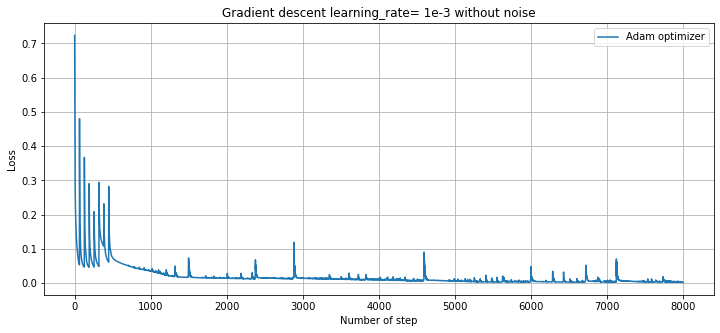

In [210]:
plt.figure(figsize=(12,5))
plt.plot(ff_with_batch[1],label='Adam optimizer')
plt.xlabel('Number of step')
plt.ylabel('Loss')
plt.title(r'Gradient descent learning_rate= 1e-3 without noise')
plt.legend()
plt.grid()

###  2. Prédiction et observation 

In [211]:
# prediction sur le train set
pred_Adam=predict(ff_with_batch[0],X_Tr)

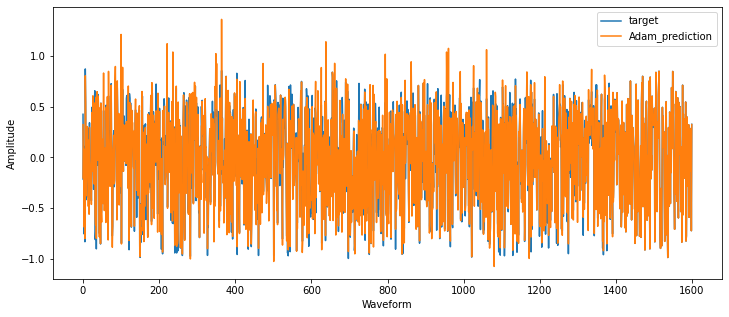

In [212]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,0],label='target')
plt.plot(pred_Adam[:,0],label='Adam_prediction')
plt.ylabel('Amplitude')
plt.xlabel("Waveform")
plt.legend()

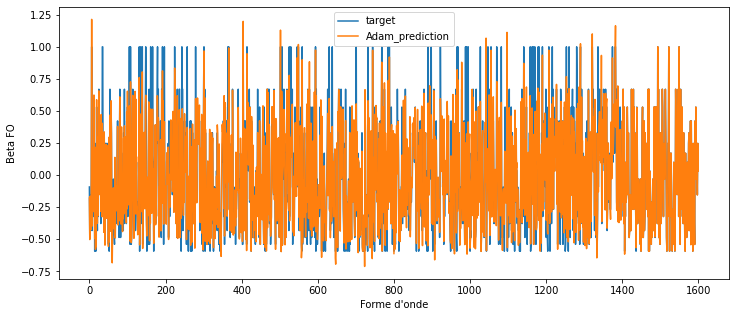

In [213]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,1],label='target')
plt.plot(pred_Adam[:,1],label='Adam_prediction')
plt.ylabel('Beta FO')
plt.xlabel("Forme d'onde")
plt.legend()

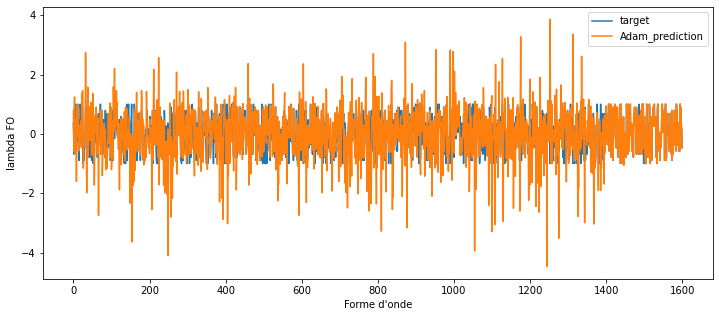

In [214]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,2],label='target')
plt.plot(pred_Adam[:,2],label='Adam_prediction')
plt.ylabel('lambda FO')
plt.xlabel("Forme d'onde")
plt.legend()

# IV. Evaluation du modèle

#### Donnée non bruitée

In [215]:
Y_test

array([[-0.82123002,  0.66952846,  0.26315789],
       [-0.30329047, -0.43212303,  0.05263158],
       [-0.26240657,  0.17121666, -0.36842105],
       ...,
       [ 0.27704212,  0.53052665, -0.26315789],
       [-0.84800242, -0.48597046,  0.26315789],
       [-0.19342935, -0.32287032, -0.26315789]])

In [216]:
Y_test[8,1]

-0.5929138877329422

###  1. Remise en forme des paramètres à prédire (signaux physiques)

In [217]:

def real_parameter_prediction(param_test,in_array):
    prediction=predict(param_test[0],in_array)
    Amp_pred=prediction[:,0]*param_test[2][1] + param_test[2][0]
    Bet_pred=prediction[:,1]*param_test[3][1] + param_test[3][0]
    lam_pred=prediction[:,2]*param_test[4][1] + param_test[4][0]
    return np.asarray([(i,j,k)for i,j,k in zip(Amp_pred,Bet_pred,lam_pred)])

In [218]:
predT=real_parameter_prediction(ff_with_batch,X_Te)

In [219]:
predT

array([[ 2.3660986e+02,  9.5967984e-01,  6.0108840e-01],
       [ 4.2545984e+02,  2.9606646e-01,  2.3053941e-01],
       [ 4.1635410e+02,  7.3969162e-01, -1.0138682e+00],
       ...,
       [ 7.4067346e+02,  1.1281172e+00, -1.8891593e+00],
       [ 2.3350510e+02,  3.7649697e-01, -4.7320600e+00],
       [ 4.5434067e+02,  2.4711889e-01, -1.1190274e+00]], dtype=float32)

In [220]:
def Y_test_transform(param_test,Y):
    h_real=Y[:,0]*param_test[2][1] + param_test[2][0]
    b_real=Y[:,1]*param_test[3][1] + param_test[3][0]
    l_real=Y[:,2]*param_test[4][1] + param_test[4][0]
    return np.asarray([(i,j,k)for i,j,k in zip(h_real,b_real,l_real)])

In [221]:
Y_TT=Y_test_transform(ff_with_batch,Y_test)

In [222]:
Y_TT[0:100,0]

array([227.62575168, 413.54958341, 428.22560404, 329.11997839,
       368.35789948, 761.15531878, 688.03128704, 751.29845679,
       706.79293228, 204.44009874, 464.39202879, 463.14175449,
       717.30814104, 286.52991031, 188.36197904, 504.73580446,
       490.20508737, 428.30801344, 740.49081265, 504.99947075,
       719.15402138, 676.45411779, 196.53442439, 471.07521356,
       565.93679801, 524.35185619, 741.74833132, 704.24945065,
       588.10871984, 684.57125689, 605.90850504, 723.86035134,
       685.2821514 , 180.99974048, 473.37686904, 590.23742823,
       749.30509143, 496.34637622, 328.97426044, 680.64411589,
       706.44273869, 580.54254131, 243.15337689, 363.41799997,
       664.6696924 , 704.7861377 , 726.04671951, 608.04515798,
       686.80663053, 477.28104037, 712.44658957, 358.94334624,
       557.0097782 , 303.46438508, 738.48119125, 799.1918337 ,
       704.6636578 , 351.33081904, 266.0064209 , 381.1786369 ,
       432.25236744, 667.1661928 , 310.27217526, 202.89

In [223]:
mse_loss(ff_with_batch[0], X_Te, Y_TT)

DeviceArray(304618.84, dtype=float32)

###  2. Visualisation des prédictions sur les trois paramètres

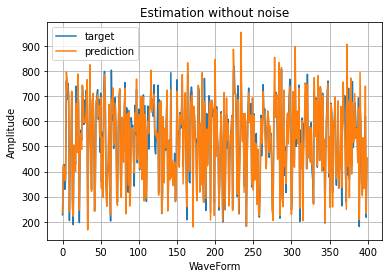

In [224]:
#plt.figure(figsize=(12,5))
plt.plot(Y_TT[:,0],label='target')
plt.plot(predT[:,0],label='prediction')
plt.ylabel('Amplitude')
plt.xlabel("WaveForm")
plt.title('Estimation without noise')
plt.grid()
plt.legend()

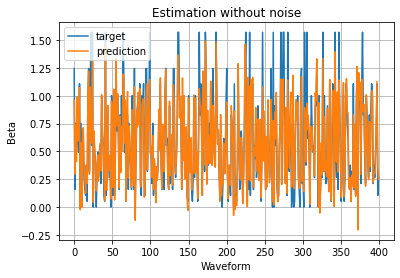

In [225]:
#plt.figure(figsize=(12,5))
plt.plot(Y_TT[:,1],label='target')
plt.plot(predT[:,1],label='prediction')
plt.ylabel('Beta')
plt.xlabel("Waveform")
plt.title('Estimation without noise')
plt.grid()
plt.legend()

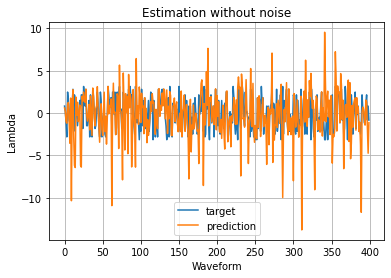

In [226]:
#plt.figure(figsize=(12,5))
plt.plot(Y_TT[:,2],label='target')
plt.plot(predT[:,2],label='prediction')
plt.ylabel('Lambda')
plt.xlabel("Waveform")
plt.title('Estimation without noise')
plt.grid()
plt.legend()

###  3. Histogramme des erreurs de prediction sur le Test_Set 

In [227]:
def LOSS_Hist(params,in_array,targets):
    preds=real_parameter_prediction(params,in_array)
    a_error =(preds[:,0]-targets[:,0])/(targets[:,0])
    b_error =(preds[:,1]-targets[:,1])/(targets[:,1]+1e-1)
    l_error =(preds[:,2]-targets[:,2])/(targets[:,2]+1e-15)
    return -20*np.log10(a_error),-20*np.log10(b_error),-20*np.log10(l_error)

In [228]:
a_err,b_err,l_err=LOSS_Hist(ff_with_batch,X_Te,Y_TT)

<ipython-input-227-1a72e282eaba>:6: RuntimeWarning: invalid value encountered in log10
  return -20*np.log10(a_error),-20*np.log10(b_error),-20*np.log10(l_error)


Text(0.5, 1.0, "Histogramme des erreurs d'amplitude sur le Test_Set")

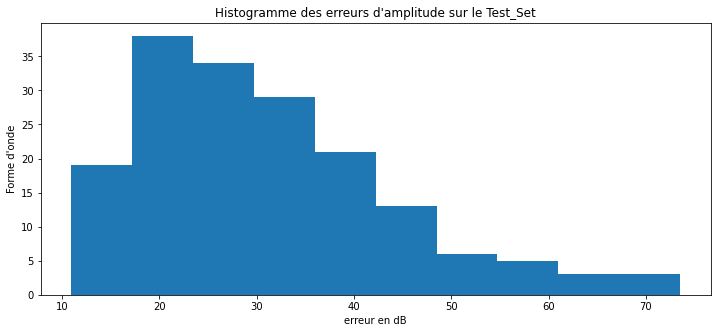

In [229]:
plt.figure(figsize=(12,5))
out=plt.hist(np.array(a_err))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs d\'amplitude sur le Test_Set')


Text(0.5, 1.0, 'Histogramme des erreurs du paramètre beta sur le Test_Set')

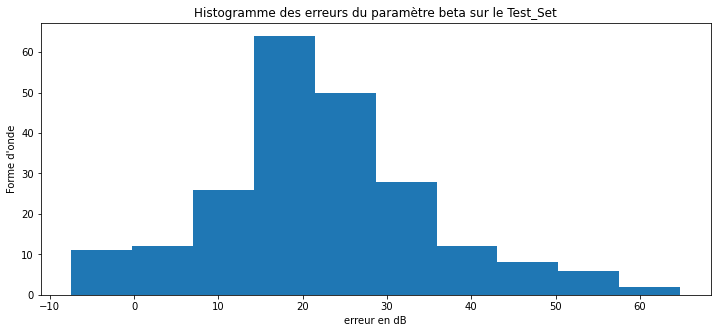

In [230]:
plt.figure(figsize=(12,5))
plt.hist(np.array(b_err))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs du paramètre beta sur le Test_Set')

Text(0.5, 1.0, 'Histogramme des erreurs du paramètre lambda sur le Test_Set')

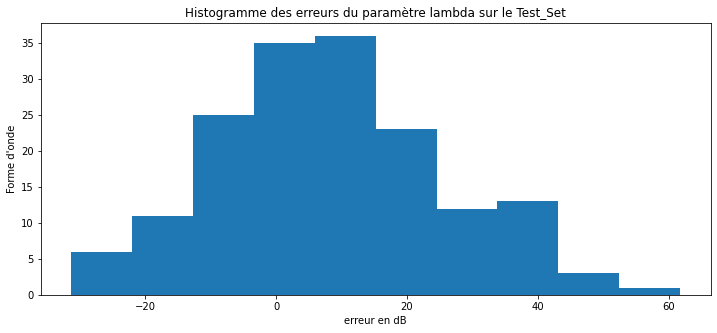

In [231]:
plt.figure(figsize=(12,5))
plt.hist(np.array(l_err))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs du paramètre lambda sur le Test_Set')

Text(0, 0.5, "Forme d'onde")

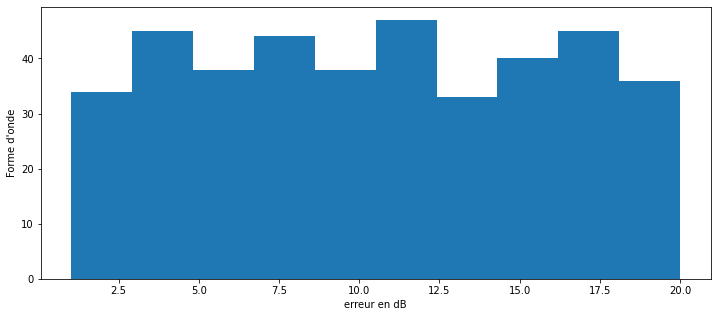

In [111]:
plt.figure(figsize=(12,5))
plt.hist(X[:,0])
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')

#### Donnée bruitée

In [111]:
predT_noise=real_parameter_prediction(ff_noise,X_Te_n)

NameError: name 'X_Te_n' is not defined

In [175]:
predT_noise

array([[ 6.3410242e+02,  1.2128396e+00,  7.7532095e-01],
       [ 4.7647125e+02,  3.3990425e-01,  1.0908634e-01],
       [ 3.5392563e+02,  6.9409895e-01, -1.0673391e+00],
       ...,
       [ 5.0800836e+02,  1.0638096e+00, -4.8547530e-01],
       [ 6.7774268e+02,  1.2441334e-01,  7.7715343e-01],
       [ 5.3197992e+02,  3.2824451e-01, -9.6884936e-01]], dtype=float32)

In [176]:
Y_TT_noise=Y_test_transform(ff_noise,Y_test)

In [177]:
mse_loss(ff_noise[0], X_Te_n, Y_TT_noise)

DeviceArray(299003.97, dtype=float32)

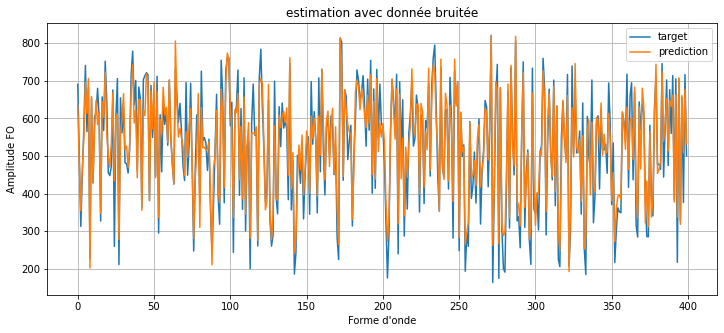

In [178]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT_noise[:,0],label='target')
plt.plot(predT_noise[:,0],label='prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.title('estimation avec donnée bruitée')
plt.grid()
plt.legend()

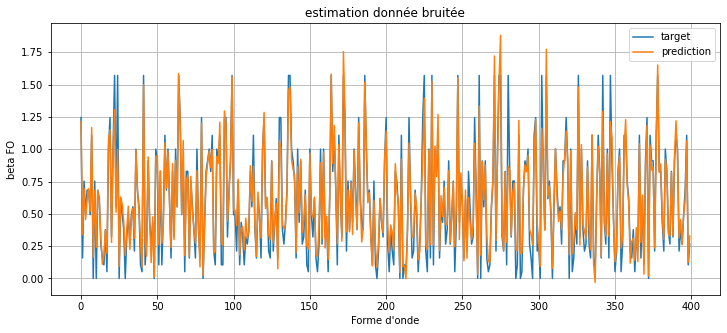

In [179]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT_noise[:,1],label='target')
plt.plot(predT_noise[:,1],label='prediction')
plt.ylabel('beta FO')
plt.xlabel("Forme d'onde")
plt.title('estimation donnée bruitée')
plt.grid()
plt.legend()

In [180]:
a_err_n,b_err_n,l_err_n=LOSS_Hist(ff_noise,X_Te_n,Y_TT_noise)

<ipython-input-169-1a72e282eaba>:6: RuntimeWarning: invalid value encountered in log10
  return -20*np.log10(a_error),-20*np.log10(b_error),-20*np.log10(l_error)


Text(0.5, 1.0, "Histogramme des erreurs d'amplitude sur le Test_Set avec donnée bruitée")

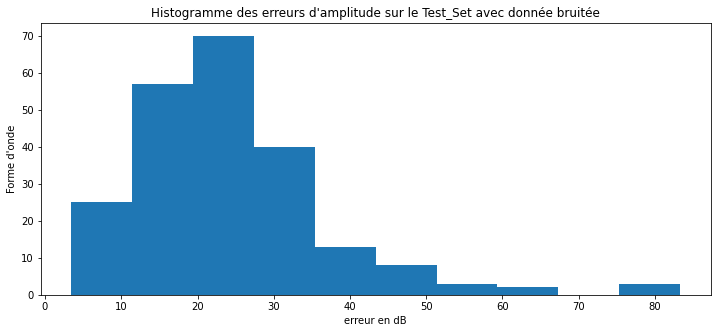

In [181]:
plt.figure(figsize=(12,5))
out=plt.hist(np.array(a_err_n))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs d\'amplitude sur le Test_Set avec donnée bruitée')



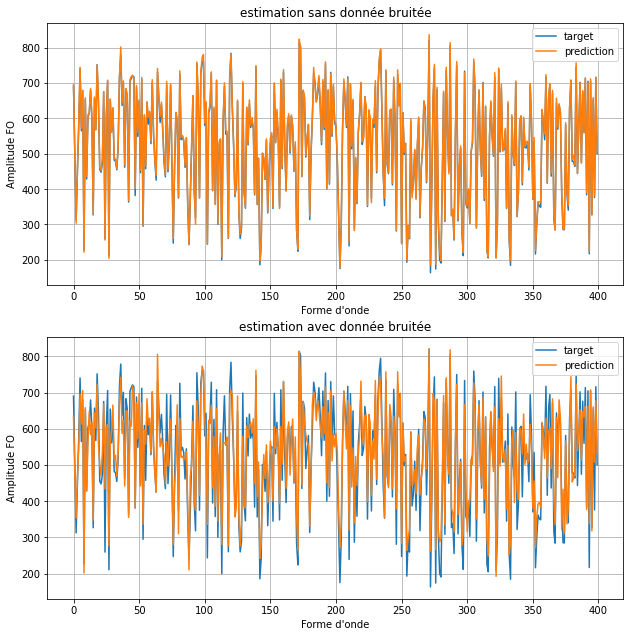

In [182]:
figure = plt.figure(figsize = (20, 20))
plt.gcf().subplots_adjust(left = 0.3, bottom = 0.3,
                       right = 0.7, top = 0.7, wspace = 0, hspace = 0.2)
axes = figure.add_subplot(2, 1, 1)
axes.set_xlabel("Forme d'onde")
axes.set_ylabel('Amplitude FO')
axes.set_title('estimation sans donnée bruitée')
axes.plot(Y_TT[:,0],label='target')
axes.plot(predT[:,0],label='prediction')
plt.grid()
plt.legend()

axes = figure.add_subplot(2, 1, 2)
axes.set_xlabel("Forme d'onde")
axes.set_ylabel('Amplitude FO')
axes.set_title('estimation avec donnée bruitée')
axes.plot(Y_TT_noise[:,0],label='target')
axes.plot(predT_noise[:,0],label='prediction')
plt.grid()
plt.legend()

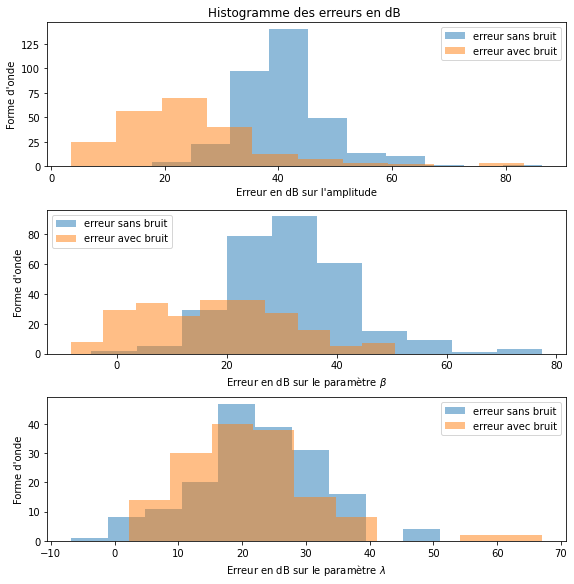

In [183]:
figure = plt.figure(figsize = (18, 18))
plt.gcf().subplots_adjust(left = 0.3, bottom = 0.3,
                       right = 0.7, top = 0.7, wspace = 0.2, hspace = 0.3)
axes = figure.add_subplot(3, 1, 1)
plt.hist(a_err, bins=10, alpha=0.5, label='erreur sans bruit') 
plt.hist(a_err_n, bins=10, alpha=0.5, label='erreur avec bruit') 
plt.legend(loc='upper right')
plt.title("Histogramme des erreurs en dB ")
plt.xlabel('Erreur en dB sur l\'amplitude')
plt.ylabel('Forme d\'onde')

axes = figure.add_subplot(3, 1, 2)
plt.hist(b_err, bins=10, alpha=0.5, label='erreur sans bruit') 
plt.hist(b_err_n, bins=10, alpha=0.5, label='erreur avec bruit') 
plt.legend(loc='upper left')
plt.xlabel(r"Erreur en dB sur le paramètre $\beta$")
plt.ylabel('Forme d\'onde')

axes = figure.add_subplot(3, 1, 3)
plt.hist(l_err, bins=10,alpha=0.5, label='erreur sans bruit') 
plt.hist(l_err_n, bins=10, alpha=0.5, label='erreur avec bruit') 
plt.legend(loc='upper right')
plt.xlabel(r'Erreur en dB sur le paramètre $\lambda$' )
plt.ylabel('Forme d\'onde')


#plt.savefig("Histo_error.png", bbox_inches='tight')
plt.show()




In [223]:
x=np.array([[2,3,4],[5,6,7]])
x.ndim

2

In [224]:
plt.savefig("Histo_error.png", bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

In [111]:
np.array(a_err).shape

(400,)

Text(0, 0.5, "Forme d'onde")

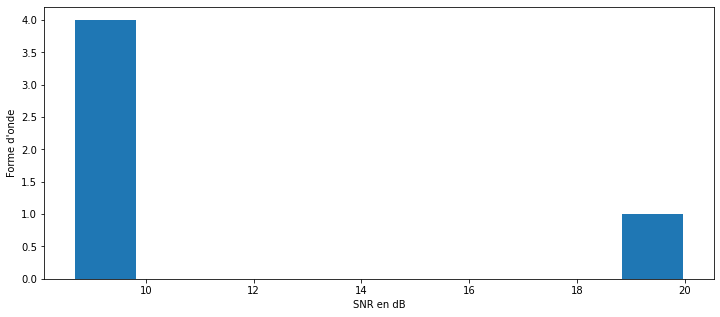

In [116]:
plt.figure(figsize=(12,5))
out=plt.hist(X[0,:])
plt.xlabel('SNR en dB')
plt.ylabel('Forme d\'onde')




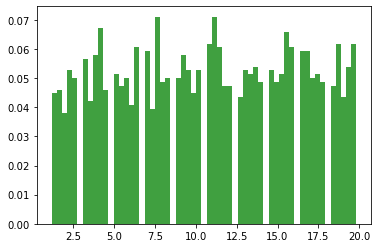

In [117]:
n, bins, patches = plt.hist(X, density=True, facecolor='g', alpha=0.75)

<BarContainer object of 400 artists>

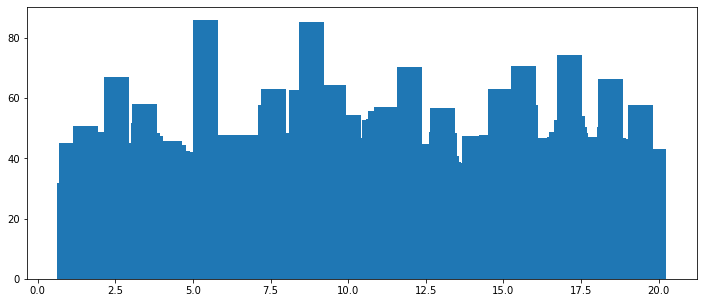

In [121]:
plt.figure(figsize=(12,5))
plt.bar(X[:,0],a_err)

<BarContainer object of 400 artists>

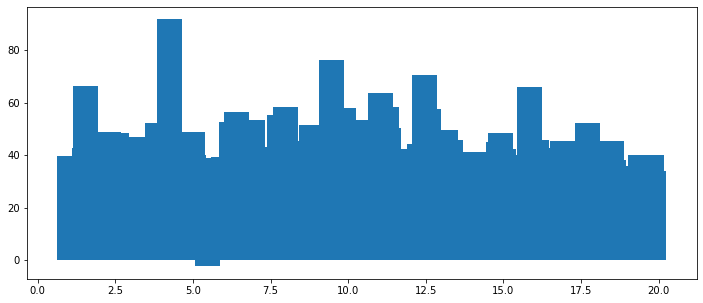

In [122]:
plt.figure(figsize=(12,5))
plt.bar(X[:,0],b_err)